# Test balanced extraction for NA sim. data & generate sim. data for the ST 

In [1]:
import JWS_SWOT_toolbox as swot
%load_ext autoreload
%autoreload 2

## 1. Import SWOT data and files first for a pass

In [2]:
# Read in the SWOT data for this pass
pass_num = 9
lat_max = 34
lat_min = 28

data_folder = '/expanse/lustre/projects/cit197/jskinner1/SWOT/CALVAL/'

_, _, shared_cycles, karin_files, nadir_files = swot.return_swot_files(data_folder, pass_num)

sample_index = 2 
indx, track_length = swot.get_karin_track_indices(karin_files[sample_index][0], lat_min, lat_max)
indxs, track_length_nadir = swot.get_nadir_track_indices(nadir_files[sample_index][0], lat_min, lat_max)
dims_SWOT = [len(shared_cycles), track_length, track_length_nadir]

karin, nadir = swot.init_swot_arrays(dims_SWOT, lat_min, lat_max, pass_num)

swot.load_karin_data(karin_files, lat_min, lat_max, karin)
swot.process_karin_data(karin)

swot.load_nadir_data(nadir_files, lat_min, lat_max, nadir)
swot.process_nadir_data(nadir)

karin.coordinates()
nadir.coordinates()

Overall SSH variance (overall_var): 0.017910151631438834
File indices with outlier variance: []
----------------------------------
Total Number of Good KaRIn strips : 190
Number of Quality Masked KaRIn strips : 118
Number of High Variance strips removed : 0

Good strips (cycle, side):
  - Cycle:  476, Side: 0
  - Cycle:  476, Side: 1
  - Cycle:  478, Side: 0
  - Cycle:  478, Side: 1
  - Cycle:  479, Side: 0
  - Cycle:  479, Side: 1
  - Cycle:  480, Side: 0
  - Cycle:  480, Side: 1
  - Cycle:  481, Side: 0
  - Cycle:  481, Side: 1
  - Cycle:  482, Side: 0
  - Cycle:  482, Side: 1
  - Cycle:  483, Side: 0
  - Cycle:  483, Side: 1
  - Cycle:  484, Side: 0
  - Cycle:  484, Side: 1
  - Cycle:  485, Side: 0
  - Cycle:  485, Side: 1
  - Cycle:  486, Side: 0
  - Cycle:  486, Side: 1
  - Cycle:  487, Side: 0
  - Cycle:  487, Side: 1
  - Cycle:  488, Side: 0
  - Cycle:  488, Side: 1
  - Cycle:  489, Side: 0
  - Cycle:  489, Side: 1
  - Cycle:  490, Side: 0
  - Cycle:  490, Side: 1
  - Cycle:  49

In [3]:
import xarray as xr

# --- compute spectra of the SWOT data
karin.window = xr.DataArray(swot.sin2_window_func(karin.track_length), dims=['line'])
nadir.window = xr.DataArray(swot.sin2_window_func(nadir.track_length), dims=['nadir_line'])
k_coords     = [karin.y_coord, karin.x_coord]
kt_coords    = [karin.t_coord, karin.y_coord, karin.x_coord]
n_coords     = [nadir.y_coord]
nt_coords    = [nadir.t_coord, nadir.y_coord]

# --- xarrays ---
# KaRIn
karin_mean           = xr.DataArray(karin.ssh_mean, coords = k_coords, dims = ['line', 'pixel'])
karin_mean_filtered  = xr.DataArray(karin.ssha_mean_highpass, coords = k_coords, dims = ['line', 'pixel'])
karin_ssh            = xr.DataArray(karin.ssh, coords = kt_coords, dims = ['sample', 'line', 'pixel']) # full ssh
karin_ssha           = xr.DataArray(karin.ssha, coords = kt_coords, dims = ['sample', 'line', 'pixel']) # ssh with time mean removed 
# Nadir
nadir_ssh            = xr.DataArray(nadir.ssh, coords = nt_coords, dims=['sample', 'nadir_line'])

# --- remove spatial mean ---
karin_spatial_mean = swot.spatial_mean(karin_ssha, ['line', 'pixel'])
karin_anomsp       = karin_ssha - karin_spatial_mean
nadir_spatial_mean = swot.spatial_mean(nadir_ssh, ['nadir_line'])
nadir_anomsp       = nadir_ssh - nadir_spatial_mean

# --- spectral analysis ---
# Karin spectra 
karin.spec_ssh          = swot.mean_power_spectrum(karin_ssh, karin.window, 'line', ['sample', 'pixel'])
karin.spec_tmean        = swot.mean_power_spectrum(karin_mean, karin.window, 'line', ['pixel'])
karin.spec_filt_tmean   = swot.mean_power_spectrum(karin_mean_filtered, karin.window, 'line', ['pixel'])
karin.spec_ssha         = swot.mean_power_spectrum(karin_ssha, karin.window, 'line', ['sample', 'pixel'])
karin.spec_alongtrack_av  = swot.mean_power_spectrum(karin_anomsp, karin.window, 'line', ['sample', 'pixel']) # Full mean spectrum
karin.spec_alongtrack_ins = swot.mean_power_spectrum(karin_anomsp, karin.window, 'line', ['pixel']) # spec at each sample
karin.wavenumbers         = karin.spec_alongtrack_ins.freq_line 

# Nadir spectra
nadir.spec_ssh            = swot.mean_power_spectrum(nadir_ssh, nadir.window, 'nadir_line', ['sample'])
nadir.spec_alongtrack_av  = swot.mean_power_spectrum(nadir_anomsp, nadir.window, 'nadir_line', ['sample'])
nadir.spec_alongtrack_ins = swot.mean_power_spectrum(nadir_anomsp, nadir.window, 'nadir_line', []) # spec at each sample
nadir.wavenumbers         = nadir.spec_alongtrack_ins.freq_nadir_line

# Tides
karin_tide             = xr.DataArray(karin.tide, coords = kt_coords, dims=['sample', 'line', 'pixel'])
karin.spec_tide        = swot.mean_power_spectrum(karin_tide, karin.window, 'line', ['sample', 'pixel'])

# --- Parseval's theorem check ---
print("KaRIn Spectrum")
_ = swot.parseval_check(
    karin_anomsp.values[1, :, :],  # Pick one sample, all lines and pixels
    karin.spec_alongtrack_ins[10],
    karin.dx,
    freq_dim='freq_line'
)
print("Nadir Spectrum")
# Check for Nadir: along-track, average spectrum
_ = swot.parseval_check(
    nadir_anomsp.values[1, :],  # Pick one sample, all nadir lines
    nadir.spec_alongtrack_ins[10],
    nadir.dy,
    freq_dim='freq_nadir_line'  # or 'freq_nadir_line' if your spectrum uses a different name
)

KaRIn Spectrum
Parseval check: var_space = 0.013504, var_spec = 0.013843, rel_error = 0.025
Nadir Spectrum
Parseval check: var_space = 0.013282, var_spec = 0.012065, rel_error = 0.0916


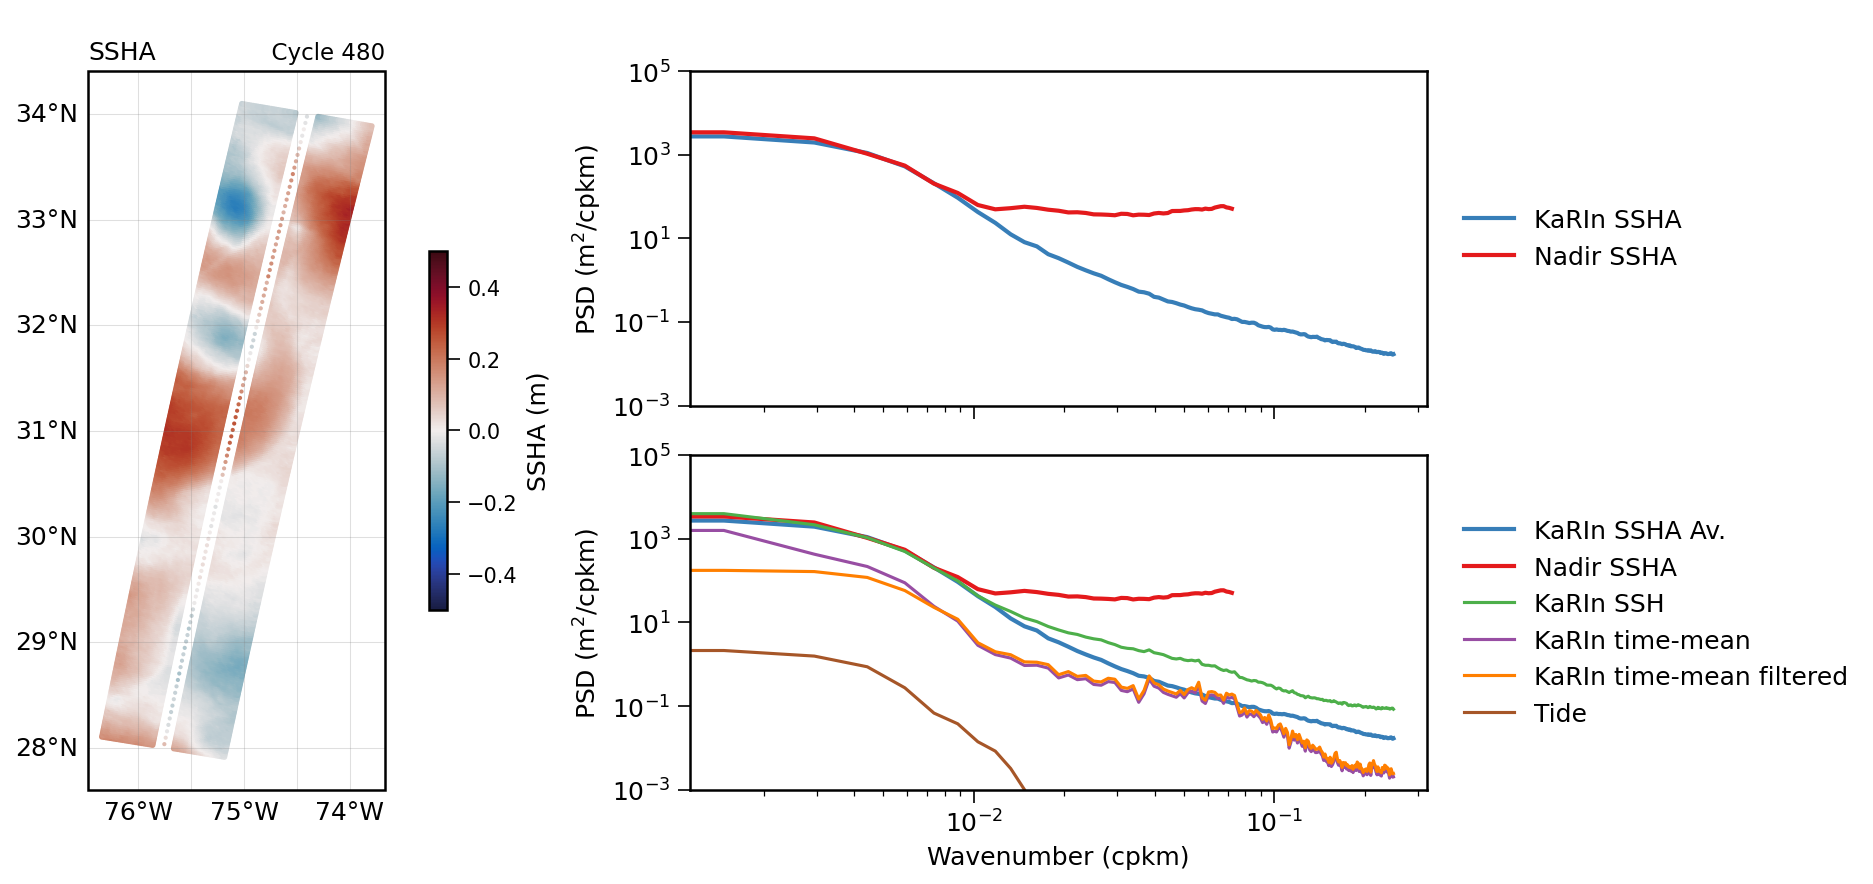

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

# Plot the fields and spectra of the SWOT data and the simulation so we can compare them
index = 3

vmax = 0.5
vmin = -0.5
ylims = (1e-3, 1e5)

swot.set_plot_style()

fig = plt.figure(figsize=(14, 6), dpi=150)

# -------- Map --------
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
cmap = cmocean.cm.balance
sc = ax1.scatter(karin.lon[index, :, :], karin.lat[index, :, :], c=karin.ssha[index, :, :], s=3, vmin=vmin, vmax=vmax, cmap=cmap, transform=ccrs.PlateCarree(), marker='o')
ax1.scatter(nadir.lon[index, :], nadir.lat[index, :], c=nadir.ssh[index, :].flatten(), vmin=vmin, vmax=vmax, cmap=cmap, s=1, marker='o', transform=ccrs.PlateCarree())
ax1.coastlines()
gl = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.25, color='gray', linestyle='-', xlabel_style={'size': 12}, ylabel_style={'size': 12})
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True 
gl.bottom_labels = True 
ax1.set_title(f'SSHA', loc='left')
ax1.set_title(f'\n  Cycle {shared_cycles[index]}', loc='right', fontsize=11)
cbar = fig.colorbar(sc, ax=ax1, orientation='vertical', shrink=0.5, pad=0.06)
cbar.ax.tick_params(labelsize=10)
cbar.set_label('SSHA (m)')

# -------- Power Spectra --------
from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 2, figure=fig)
ax2 = fig.add_subplot(gs[0, 1])
ax2.loglog(karin.wavenumbers*1e3, karin.spec_alongtrack_av, label='KaRIn SSHA', linewidth=2)
ax2.loglog(nadir.wavenumbers*1e3, nadir.spec_alongtrack_av, label='Nadir SSHA', linewidth=2)
ax2.set_ylabel('PSD (m$^2$/cpkm)')
#ax2.set_title('Power Spectra')
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
ax2.tick_params(axis='x', which='both', labelbottom=False)
ax2.set_ylim(ylims)
ax3 = fig.add_subplot(gs[1, 1], sharex=ax2)
ax3.loglog(karin.wavenumbers*1e3, karin.spec_alongtrack_av, label='KaRIn SSHA Av.', linewidth=2)
# ax3.loglog(karin.wavenumbers*1e3, karin.spec_alongtrack_ins[index], label='KaRIn SSHA', linewidth=2)
ax3.loglog(nadir.wavenumbers*1e3, nadir.spec_alongtrack_av, label='Nadir SSHA', linewidth=2)
ax3.loglog(karin.wavenumbers*1e3, karin.spec_ssh, label='KaRIn SSH', linewidth=1.5)
ax3.loglog(karin.wavenumbers*1e3, karin.spec_tmean, label='KaRIn time-mean', linewidth=1.5)
ax3.loglog(karin.wavenumbers*1e3, karin.spec_filt_tmean, label='KaRIn time-mean filtered', linewidth=1.5)
ax3.loglog(karin.wavenumbers*1e3, karin.spec_tide, label='Tide', linewidth=1.5)
# # ax3.loglog(spec_nadir_mean.freq_nadir_line*1e3, spec_nadir_mean, label='Nadir time-mean', linewidth=1.5)
# ax3.loglog(spec_nadir_mean.freq_nadir_line*1e3, spec_nadir_mean_filtered, label='Nadir time-mean filtered', linewidth=1.5)
ax3.set_xlabel('Wavenumber (cpkm)')
ax3.set_ylabel('PSD (m$^2$/cpkm)')
ax3.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
#ax3.grid(True, which='both', linestyle=':', linewidth=0.5)
ax3.set_ylim(ylims)
plt.tight_layout()
plt.show()


## 2. Now import and process the NA simulation data for same pass and location

In [5]:
import os
import scipy.io as sio
from datetime import datetime
import numpy as np
from scipy.interpolate import griddata

def interpolate_swot_pass_griddata_optimized(XC, YC, ssh_model, lon_swot, lat_swot, buffer=0.5):

    # bouding box
    lat_min, lat_max = lat_swot.min(), lat_swot.max()
    lon_min, lon_max = lon_swot.min(), lon_swot.max()

    # mask it
    XC_adj = (XC + 180) % 360 - 180
    mask = ((YC >= lat_min - buffer) & (YC <= lat_max + buffer) &
            (XC_adj >= lon_min - buffer) & (XC_adj <= lon_max + buffer))
    
    if lon_max - lon_min > 180:
         mask = ((YC >= lat_min - buffer) & (YC <= lat_max + buffer) &
                ((XC_adj >= lon_min - buffer) | (XC_adj <= lon_max + buffer)))

    if not np.any(mask):
        return np.full(lat_swot.shape, np.nan)

    YC_subset = YC[mask]
    XC_adj_subset = XC_adj[mask]
    ssh_model_subset = ssh_model[mask]

    source_points = np.column_stack((YC_subset, XC_adj_subset))
    source_values = ssh_model_subset
    target_points = np.column_stack((lat_swot.ravel(), lon_swot.ravel()))

    ssh_interpolated = griddata(source_points, source_values, target_points,
                                method='linear', fill_value=np.nan)

    return ssh_interpolated.reshape(lat_swot.shape)


def extract_pass_swath(pass_num, pass_coords, data_folder, date_min, date_max, lat_min=None, lat_max=None):

    date_fmt = "%Y_%m_%d"
    tmin = datetime.strptime(date_min, date_fmt)
    tmax = datetime.strptime(date_max, date_fmt)

    mat_files = sorted([f for f in os.listdir(data_folder) if f.endswith(".mat")])
    if not mat_files:
        raise FileNotFoundError("No .mat files found in data folder.")

    sample_file = os.path.join(data_folder, mat_files[0])
    mat = sio.loadmat(sample_file)
    XC = mat['XC']
    YC = mat['YC']

    entry = next((e for e in pass_coords if e[0] == pass_num), None)
    if entry is None:
        raise ValueError(f"Pass {pass_num} not found in pass_coords.")

    lat = entry[1]
    lon = (entry[2] + 180) % 360 - 180

    if lat_min is not None and lat_max is not None:
        if lat.ndim != 2:
            raise ValueError("Expected 2D lat/lon arrays for filtering")
        
        lat_mask = (lat >= lat_min) & (lat <= lat_max)
        row_mask = np.any(lat_mask, axis=1)

        # If the filter removes all data, return empty arrays to avoid processing.
        if not np.any(row_mask):
            print(f"Warning: The latitude filter ({lat_min}, {lat_max}) removed all SWOT data for pass {pass_num}.")
            return np.empty((0,)), np.empty((0,)), np.empty((0,))

        # Apply the mask to the coordinates that will be used in the loop
        lat = lat[row_mask, :]
        lon = lon[row_mask, :]
        
    ssh_list = []

    for fname in mat_files:
        try:
            date_str = fname.replace("snapshot_", "").replace(".mat", "")
            t = datetime.strptime(date_str, date_fmt)
        except ValueError:
            continue

        if not (tmin <= t <= tmax):
            continue

        fpath = os.path.join(data_folder, fname)
        mat = sio.loadmat(fpath)
        ssh = mat['ssh']
        
        ssh_interpolated = interpolate_swot_pass_griddata_optimized(XC, YC, ssh, lon, lat)
        ssh_list.append(ssh_interpolated)

    if not ssh_list:
        raise RuntimeError("No valid snapshot files found in time range.")

    ssh_all = np.stack(ssh_list)
    
    return ssh_all, lat, lon

In [ ]:
# Use the SWOT Pass coordinates to extract a pass from the simulation data 
import pickle 

data_folder = "/expanse/lustre/projects/cit197/jskinner1/NA_daily_snapshots"

date_min = "2026_03_31" # calval date range
date_max = "2026_07_09"

date_min = "2024_03_31" # full date range (and more some)
date_max = "2027_07_09"

with open("SWOT_pass_coordinates.pkl", "rb") as f:
    pass_coords = pickle.load(f)

ssh, lat, lon = extract_pass_swath(pass_num, pass_coords, data_folder, date_min, date_max, lat_min, lat_max)
print("ssh shape:", ssh.shape)  # (ntime, ny, nx)
print("lat shape:", lat.shape)
print("lon shape:", lon.shape)

print("SWOT lat shape:", karin.lat.shape)
print("SWOT lon shape:", karin.lon.shape)

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

def sample_NA_sim_to_karin_and_nadir(ssh_model, lat_model, lon_model, 
                                     karin_target_shape, nadir_target_shape,
                                     return_full_sim=True):

    ntime, track_len, NA_total_width = ssh_model.shape
    _, track_len_target, total_width = karin_target_shape
    _, track_len_nadir = nadir_target_shape

    swath_width = 25
    track_axis = np.linspace(0, track_len - 1, track_len_target)

    # Interpolate SSH
    ssh_interp = np.empty((ntime, track_len_target, NA_total_width))
    for i in range(ntime):
        f = interp1d(np.arange(track_len), ssh_model[i], axis=0, kind='linear', 
                     bounds_error=False, fill_value='extrapolate')
        ssh_interp[i] = f(track_axis)

    # Interpolate LAT and LON
    lat_interp = interp1d(np.arange(track_len), lat_model, axis=0, kind='linear',
                          bounds_error=False, fill_value='extrapolate')(track_axis)
    lon_interp = interp1d(np.arange(track_len), lon_model, axis=0, kind='linear',
                          bounds_error=False, fill_value='extrapolate')(track_axis)

    # Build KaRIn swath: gap in center, swath_width = 25 pixels per side
    NA_sim_karin_ssh = np.full((ntime, track_len_target, total_width), np.nan)
    NA_sim_karin_ssh[:, :, :swath_width] = ssh_interp[:, :, :swath_width]
    NA_sim_karin_ssh[:, :, 35:60] = ssh_interp[:, :, 35:60]

    NA_sim_karin_lat = np.full((track_len_target, total_width), np.nan)
    NA_sim_karin_lon = np.full((track_len_target, total_width), np.nan)
    NA_sim_karin_lat[:, :swath_width] = lat_interp[:, :swath_width]
    NA_sim_karin_lon[:, :swath_width] = lon_interp[:, :swath_width]
    NA_sim_karin_lat[:, 35:60] = lat_interp[:, 35:60]
    NA_sim_karin_lon[:, 35:60] = lon_interp[:, 35:60]

    # Sample Nadir track
    nadir_track_axis = np.linspace(0, track_len_target - 1, track_len_nadir).astype(int)
    NA_sim_nadir_ssh = ssh_interp[:, nadir_track_axis, 30]
    NA_sim_nadir_lat = lat_interp[nadir_track_axis, 30]
    NA_sim_nadir_lon = lon_interp[nadir_track_axis, 30]

    if return_full_sim:
        return (
            NA_sim_karin_ssh, NA_sim_karin_lat, NA_sim_karin_lon,
            NA_sim_nadir_ssh, NA_sim_nadir_lat, NA_sim_nadir_lon,
            ssh_interp, lat_interp, lon_interp
        )
    else:
        return (
            NA_sim_karin_ssh, NA_sim_karin_lat, NA_sim_karin_lon,
            NA_sim_nadir_ssh, NA_sim_nadir_lat, NA_sim_nadir_lon
        )

NA_karin_ssh, NA_karin_lat, NA_karin_lon, NA_nadir_ssh, NA_nadir_lat, NA_nadir_lon, full_ssh, full_lat, full_lon = sample_NA_sim_to_karin_and_nadir(
    ssh,
    lat, 
    lon,
    karin.ssha.shape, 
    nadir.ssha.shape
)

print(NA_karin_ssh.shape) # check
print(karin.ssha.shape)

print(NA_nadir_ssh.shape) # check
print(nadir.ssha.shape)
print(full_ssh.shape)

In [ ]:
# Now the data is processed we can init all out data classes with NA_Karin/Nadir
ncycles = NA_karin_ssh.shape[0]
track_length_karin =  NA_karin_ssh.shape[1]
track_length_nadir = NA_nadir_ssh.shape[1]
dims_NA = [ncycles, track_length_karin, track_length_nadir]

karin_NA, nadir_NA = swot.init_swot_arrays(dims_NA, lat_min, lat_max, pass_num) # init a class for the karin/nadir parts of the data
karin_NA.ssh_orig = full_ssh[:, :, 0:60]
karin_NA.ssh = NA_karin_ssh
karin_NA.ssha = NA_karin_ssh - np.nanmean(NA_karin_ssh, axis=(1, 2), keepdims=True)
karin_NA.lat = NA_karin_lat
karin_NA.lon = NA_karin_lon

nadir_NA.ssh = NA_nadir_ssh
nadir_NA.ssha = NA_nadir_ssh - np.nanmean(NA_nadir_ssh, axis=(1), keepdims=True)
nadir_NA.lat = NA_nadir_lat
nadir_NA.lon = NA_nadir_lon

# compute the dx, dy, dy_nadir of the grids -- in [m]
karin_NA.distances()
nadir_NA.distances()

# Builds the coordinate grids -- in [m]
karin_NA.coordinates()
nadir_NA.coordinates()

print(karin_NA.ssh.shape)
print(karin_NA.ssh_orig.shape)

In [11]:
# Now compute the spectra of our NA simulation as a SWOT track 

# --- windows and grids ---
karin_NA.window = xr.DataArray(swot.sin2_window_func(karin_NA.track_length), dims=['line'])
nadir_NA.window = xr.DataArray(swot.sin2_window_func(nadir_NA.track_length), dims=['nadir_line'])
k_coords     = [karin_NA.y_coord, karin_NA.x_coord]
kt_coords    = [karin_NA.t_coord, karin_NA.y_coord, karin_NA.x_coord]
n_coords     = [nadir_NA.y_coord]
nt_coords    = [nadir_NA.t_coord, nadir_NA.y_coord]

# --- xarrays ---
karin_ssh            = xr.DataArray(karin_NA.ssh, coords = kt_coords, dims = ['sample', 'line', 'pixel'])
nadir_ssh            = xr.DataArray(nadir_NA.ssh, coords = nt_coords, dims=['sample', 'nadir_line'])

# --- remove spatial mean ---
karin_spatial_mean = swot.spatial_mean(karin_ssh, ['line', 'pixel'])
karin_anomsp       = karin_ssh - karin_spatial_mean

nadir_spatial_mean = swot.spatial_mean(nadir_ssh, ['nadir_line'])
nadir_anomsp       = nadir_ssh - nadir_spatial_mean

# --- spectral analysis ---
# Karin spectra 
karin_NA.spec_ssh            = swot.mean_power_spectrum(karin_ssh, karin_NA.window, 'line', ['sample', 'pixel'])
karin_NA.spec_alongtrack_av  = swot.mean_power_spectrum(karin_anomsp, karin_NA.window, 'line', ['sample', 'pixel']) # Full mean spectrum
karin_NA.wavenumbers         = karin_NA.spec_alongtrack_av.freq_line 

# Nadir spectra
nadir_NA.spec_ssh            = swot.mean_power_spectrum(nadir_ssh, nadir_NA.window, 'nadir_line', ['sample'])
nadir_NA.spec_alongtrack_av  = swot.mean_power_spectrum(nadir_anomsp, nadir_NA.window, 'nadir_line', ['sample'])
nadir_NA.wavenumbers         = nadir_NA.spec_alongtrack_av.freq_nadir_line


# --- Parseval's theorem check ---
print("KaRIn Spectrum")
_ = swot.parseval_check(
    karin_anomsp.values[1, :, :],  # Pick one sample, all lines and pixels
    karin_NA.spec_alongtrack_av,
    karin_NA.dx,
    freq_dim='freq_line'
)
print("Nadir Spectrum")
# Check for Nadir: along-track, average spectrum
_ = swot.parseval_check(
    nadir_anomsp.values[1, :],  # Pick one sample, all nadir lines
    nadir_NA.spec_alongtrack_av,
    nadir_NA.dy,
    freq_dim='freq_nadir_line'  # or 'freq_nadir_line' if your spectrum uses a different name
)

KaRIn Spectrum
Parseval check: var_space = 0.18944, var_spec = 0.096474, rel_error = 0.491
Nadir Spectrum
Parseval check: var_space = 0.18584, var_spec = 0.094308, rel_error = 0.493


#### Plot the NA sim and SWOT data on the same plot for comparison

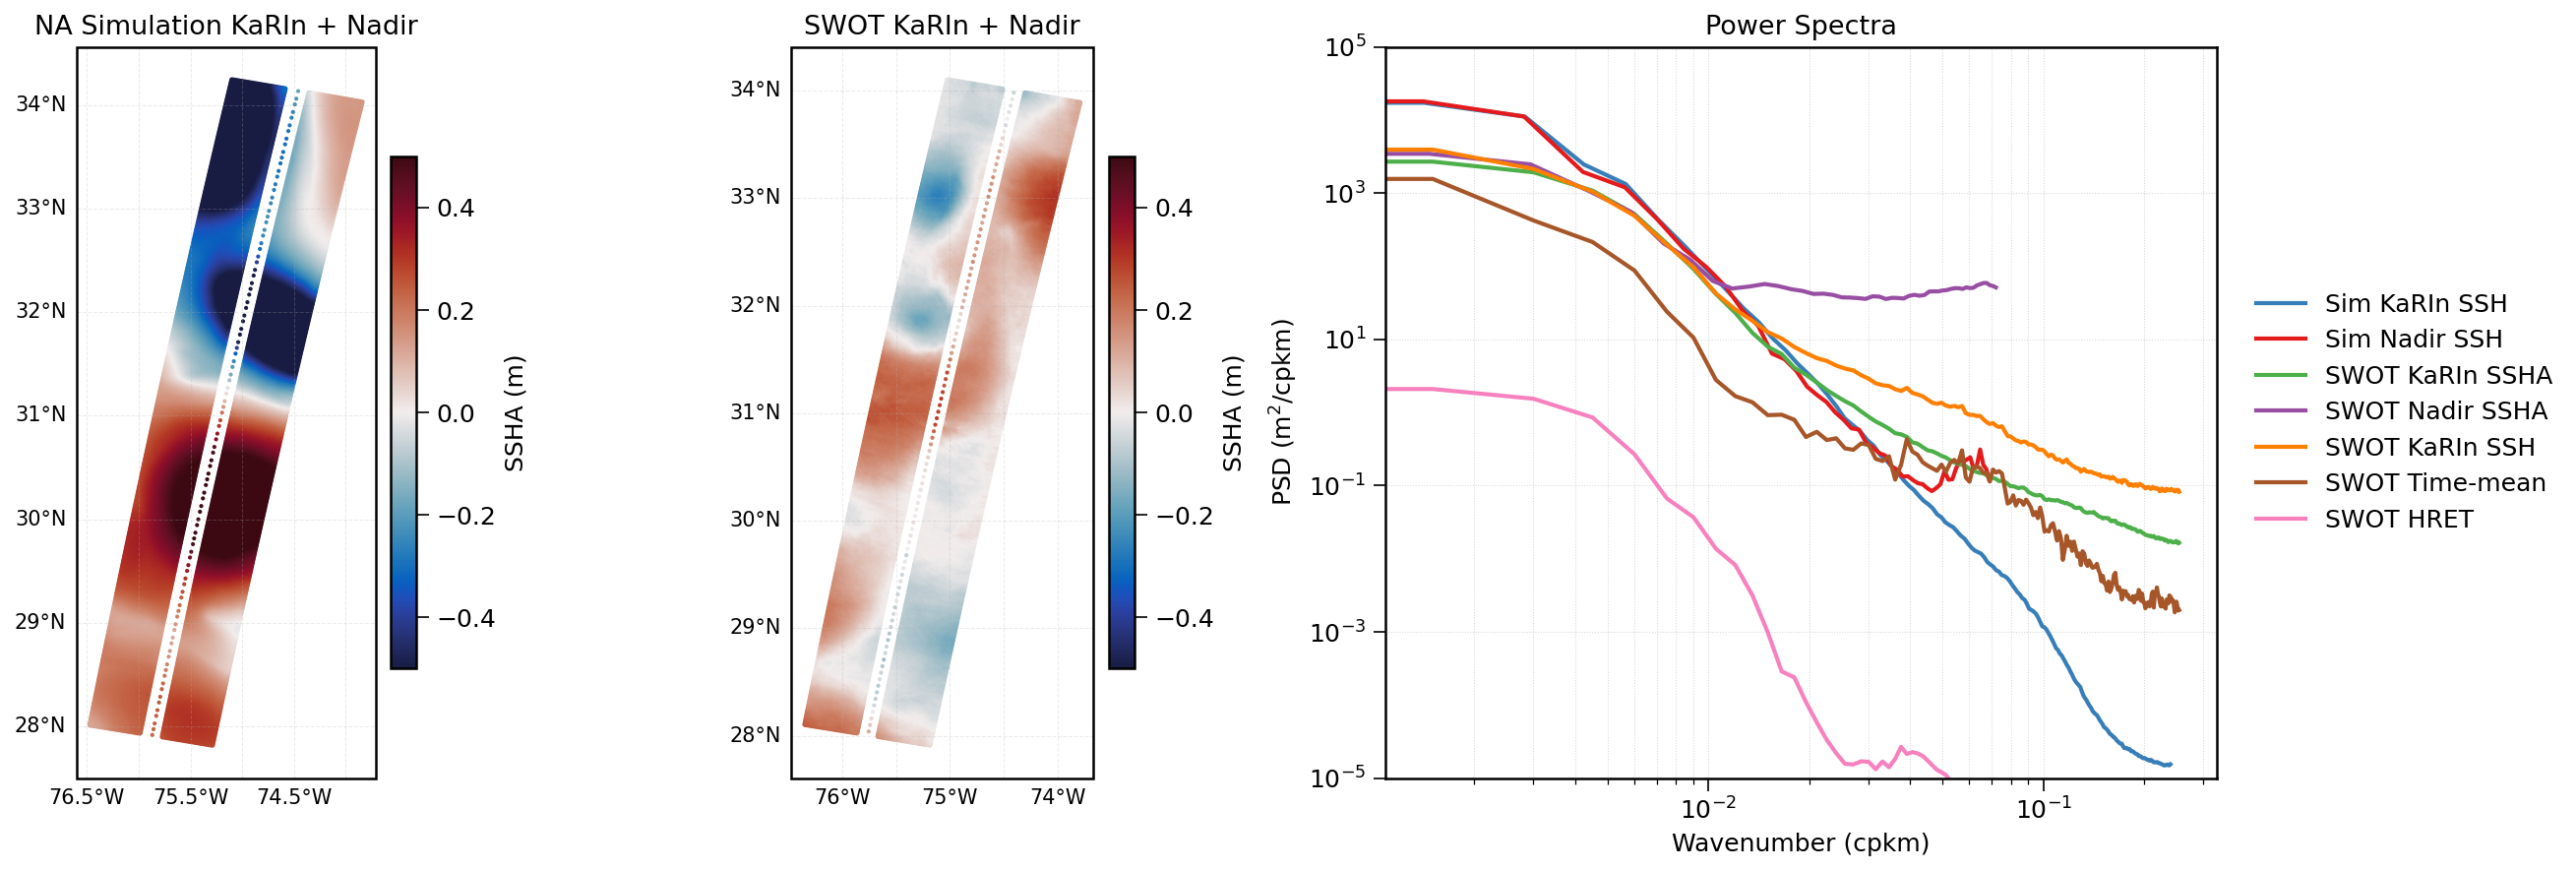

In [12]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cmocean

swot.set_plot_style()

index = 2
vmin, vmax = -0.5, 0.5
ylims = (1e-5, 1e5)
cmap = cmocean.cm.balance

fig = plt.figure(figsize=(18, 6), dpi=150)
gs = GridSpec(1, 3, width_ratios=[1, 1, 1.6], figure=fig)

# ───── Simulation Map ─────
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
sc0 = ax0.scatter(
    NA_karin_lon.flatten(), NA_karin_lat.flatten(),
    c=karin_NA.ssha[index].flatten(), s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o'
)
ax0.scatter(
    NA_nadir_lon, NA_nadir_lat, c=nadir_NA.ssha[index], vmin=vmin, vmax=vmax,
    cmap=cmap, s=1, marker='o', transform=ccrs.PlateCarree()
)
ax0.coastlines()
ax0.set_title("NA Simulation KaRIn + Nadir")
gl0 = ax0.gridlines(draw_labels=True, linewidth=0.5, alpha=0.25)
gl0.top_labels = gl0.right_labels = False
cbar0 = fig.colorbar(sc0, ax=ax0, orientation='vertical', shrink=0.7, pad=0.03)
cbar0.set_label("SSHA (m)")

# ───── SWOT Map ─────
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
sc1 = ax1.scatter(
    karin.lon[index], karin.lat[index],
    c=karin.ssha[index], s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o'
)
ax1.scatter(
    nadir.lon[index], nadir.lat[index],
    c=nadir.ssh[index], s=1, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o'
)
ax1.coastlines()
ax1.set_title(f'SWOT KaRIn + Nadir')
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.25)
gl1.top_labels = gl1.right_labels = False
cbar1 = fig.colorbar(sc1, ax=ax1, orientation='vertical', shrink=0.7, pad=0.03)
cbar1.set_label("SSHA (m)")

# ───── Power Spectrum ─────
ax2 = fig.add_subplot(gs[0, 2])
ax2.loglog(karin_NA.wavenumbers * 1e3, karin_NA.spec_alongtrack_av, label='Sim KaRIn SSH', linewidth=2)
ax2.loglog(nadir_NA.wavenumbers * 1e3, nadir_NA.spec_alongtrack_av, label='Sim Nadir SSH', linewidth=2)
#ax2.loglog(karin_NA.wavenumbers * 1e3, karin_NA.spec_ssh, label='Sim KaRIn SSH', linewidth=1.5)

ax2.loglog(karin.wavenumbers * 1e3, karin.spec_alongtrack_av, label='SWOT KaRIn SSHA', linewidth=2)
ax2.loglog(nadir.wavenumbers * 1e3, nadir.spec_alongtrack_av, label='SWOT Nadir SSHA', linewidth=2)
ax2.loglog(karin.wavenumbers * 1e3, karin.spec_ssh, label='SWOT KaRIn SSH', linewidth=2.0)
ax2.loglog(karin.wavenumbers * 1e3, karin.spec_tmean, label='SWOT Time-mean', linewidth=2.0)
#ax2.loglog(karin.wavenumbers * 1e3, karin.spec_filt_tmean, label='SWOT Filtered', linewidth=1.2)
ax2.loglog(karin.wavenumbers * 1e3, karin.spec_tide, label='SWOT HRET', linewidth=2.0)

ax2.set_xlabel("Wavenumber (cpkm)")
ax2.set_ylabel("PSD (m$^2$/cpkm)")
ax2.set_ylim(ylims)
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
ax2.grid(True, which='both', linestyle=':', linewidth=0.5)
ax2.set_title("Power Spectra")

plt.tight_layout()
plt.show()


## 3. Estimate the balanced and unbalanced components of the SWOT data

We now extract the balanced and unbalanced signals in the KaRIn and Nadir data by fitting models to their spectra.

The balanced part of the KarIn spectrum is fitted with

# $\frac{A_b}{(1 + (\lambda_b  k)^{s_b})}$

and the unbalanced part is fitted to the model: 

# $\frac{A_n}{(1 + (\lambda_n  k)^2)^{s_n/2}}$

Where $\lambda_n = 100$ km is fixed in the function due to the poor constraint on this parameter

Note that there is also the option to fit to the Mattern model

## $\frac{2\pi\Gamma(\gamma+1/2)(2\gamma)^{\gamma}}{\Gamma(\gamma)\lambda^{2\gamma}}(\frac{2\gamma}{\lambda^{2}}+4\pi^{2}k^{2})^{-\gamma+1/2}$

### Model balanced and unbalanced signal from KaRIn

Text(0.5, 1.0, 'Weighted fit KaRIn data')

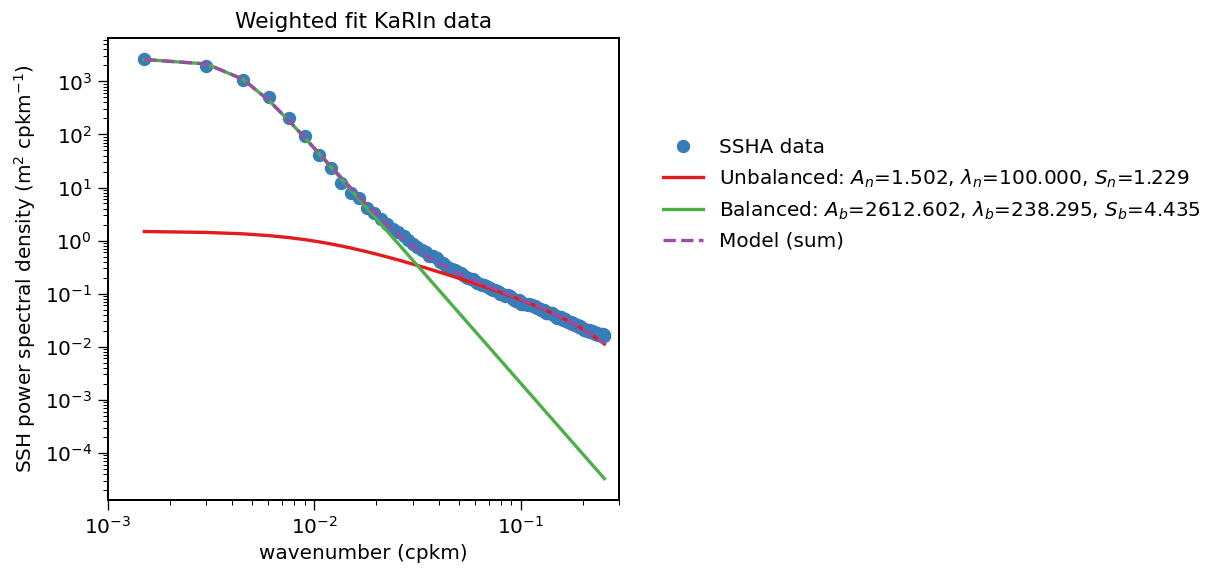

In [39]:
# use the positive half of the along track averaged spectrum for our model fits
k_karin = (karin.wavenumbers[int(karin.track_length/2):]) # this is in units [1/m] 
karin_spec_sample_mean = karin.spec_alongtrack_av[int(karin.track_length/2):]

# fit the model to the data
poptcwg_karin, pcovcwg_karin = swot.fit_spectrum(karin, karin.spec_alongtrack_av, swot.karin_model)

# plot the weighted fit
spbalanced = swot.balanced_model(k_karin[1:],*poptcwg_karin[0:3])
spunbalanced = swot.unbalanced_model(k_karin,*poptcwg_karin[3:7])
plt.figure(figsize=(5.5,5), dpi=120)
k_km = k_karin * 1e3 # wavenumbers in km for plotting
plt.loglog(k_km[1:], karin_spec_sample_mean[1:],'o', label = 'SSHA data')
plt.loglog(k_km[1:], spunbalanced[1:],label = r'Unbalanced: $A_n$=%5.3f, $\lambda_n$=%5.3f, $S_n$=%5.3f' % (poptcwg_karin[3], 100, poptcwg_karin[5]))
plt.loglog(k_km[1:], spbalanced,label = r'Balanced: $A_b$=%5.3f, $\lambda_b$=%5.3f, $S_b$=%5.3f' % (poptcwg_karin[0], poptcwg_karin[1]*1e-3, poptcwg_karin[2]))
plt.loglog(k_km[1:], (spunbalanced[1:]+spbalanced),'--',label = 'Model (sum)')
plt.xlabel('wavenumber (cpkm)')
plt.ylabel('SSH power spectral density (m$^2$ cpkm$^{-1}$)')
plt.legend(loc = 'lower left', bbox_to_anchor=(1.05, 0.5))
plt.xlim(1e-3, 3e-1)
plt.title('Weighted fit KaRIn data')

### Model balanced and unbalanced signal from Nadir

In [1]:
k_nadir = (nadir.wavenumbers[int(nadir.track_length/2):])# wavenumbers of the nadir data in units [1/m]
nadir_spec_sample_mean = nadir.spec_alongtrack_av[int(nadir.track_length/2):]

# Assume k_nadir, spec_nadir_sample_mean, track_length, poptcwg_karin already obtained from the KaRIn fit
poptcwg_nadir, covcwg_nadir = swot.fit_nadir_spectrum(nadir, nadir.spec_alongtrack_av, poptcwg_karin)
print("Fitted noise floor N =", poptcwg_nadir[0])

# plot the weighted fit
spnoise_nadir = swot.nadir_noise_model(k_nadir, poptcwg_nadir[0])
plt.figure(figsize=(5.5,5), dpi=120)
plt.loglog(k_nadir[1:]*1e3, nadir_spec_sample_mean[1:],' o', label = 'SSHA Data')
plt.loglog(k_nadir*1e3, spnoise_nadir, label = r'Noise: $N$=%5.3f' % poptcwg_nadir[0])
plt.loglog(k_karin[1:]*1e3, spbalanced,'-', label = r'Balanced (KaRIn): $A_b$=%5.3f, $\lambda_b$=%5.3f' % tuple(poptcwg_karin[0:2]))
plt.loglog(k_karin[1:]*1e3, (spbalanced + spnoise_nadir[:1]), '--', label = 'Model (sum)')
plt.xlabel('wavenumber (cpkm)')
plt.ylabel('SSH power spectral density (m$^2$ cpkm$^{-1}$)')
plt.legend(loc = 'lower left', bbox_to_anchor=(1.05, 0.5))
plt.xlim(1e-3, 3e-1)
# plt.ylim(1, 1e3)
plt.title('Weighted fit nadir data')

NameError: name 'nadir' is not defined

## 4. Generate Covariances for the SWOT data

We now generate covariance functions for our spectrum models of the SWOT data to synthesize the noise component of the SWOT spectrum. We wont extend the target grid at the stage, we will keep it at 60. 


In [41]:
# Parameters from spectral estimation above
A_b, lam_b, s_param = poptcwg_karin[0], poptcwg_karin[1], poptcwg_karin[2] # balanced params from fit
A_n, s_n, lam_n = poptcwg_karin[3], poptcwg_karin[5], 1e5 # unbalanced params from fit, we fixed lam_k to 100km in unbalanced model above
N_n = poptcwg_nadir[0] # Nadir noise

# Pull in our parameters
ny = 2*karin.swath_width
gap = karin.middle_width
delta_kx = karin.dx
delta_ky = karin.dy
delta_n = nadir.dy
nx = karin.track_length
nn = nadir.track_length 

# balanced covariance functions
S = lambda k: A_b / (1 + (lam_b * k)**s_param)
c = swot.cov(S, 5000000, 10000e3)

# unbalanced covaiance functions
cutoff = 1e3
sigma = 2 * np.pi * cutoff/np.sqrt(2*np.log(2)) 
Sk = lambda k: A_n / (1 + (lam_n * k)**2)**(s_n / 2) * np.exp(-0.5 * ((sigma**2)*(k**2))) # adds guassian taper to smallest scales
nk = swot.cov(Sk, 5000, 10000e3)
sigma = np.sqrt(N_n / (2 * delta_n))

# Observation points
xk, yk = swot.make_karin_points(karin) 
xn, yn = swot.make_nadir_points(karin, nadir)

xobs = np.concatenate((xk, xn))
yobs = np.concatenate((yk, yn))

# Covariance matrices
C = swot.build_covariance_matrix(c, xobs, yobs)
N, Nk = swot.build_noise_matrix(nk, xk, yk, sigma, nn, nx * ny)

# Cholesky decompositions
F = swot.cholesky_decomp(C, "C")
Fk = swot.cholesky_decomp(Nk, "Nk")

# Estimate the signal from a synthetic SWOT observation
# Signal and noise
h, eta, eta_k, eta_n = swot.generate_signal_and_noise(F, Fk, sigma, nx * ny, nn) # Synthetic signal and noise 

# Target grid
xt, yt, nxt, nyt = swot.make_target_grid(karin, extend=False) # Our target is the NA simulation grid

# Estimate signal
ht = swot.estimate_signal_on_target(c, xt, yt, xobs, yobs, C, N, h + eta)

Variance from spectrum:   0.011938
Variance from covariance: 0.011938
Variance from spectrum:   0.000041
Variance from covariance: 0.000041
Calculating covariance matrices...
Performing Cholesky decomposition for C...
Cholesky(C) time: 36.3677 seconds
Performing Cholesky decomposition for Nk...
Cholesky(Nk) time: 35.2996 seconds
Estimating signal on target points...
Signal estimation time: 112.3844 seconds


In [ ]:
# Check the generation 
fig, axes = plt.subplots(
    5, 1, figsize=(8, 13), sharex=True,
    gridspec_kw={'hspace': 0.35}
)

vmin = -0.2 
vmax = 0.2

axes[0].scatter(xk * 1e-3, yk * 1e-3, s=1,  c='blue', label='Karin', alpha=0.5)
axes[0].scatter(xn * 1e-3, yn * 1e-3, s=1, c='red',  label='Nadir', alpha=0.8)
axes[0].set_title('Karin and Nadir Grid')
axes[0].set_ylabel('cross-track (km)')
# axes[0].set_xlim(*x_lim)
# axes[0].set_ylim(-25, 150)
axes[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

axes[1].scatter(1e-3 * xobs, 1e-3 * yobs, c=h,  s=1, vmin=vmin, vmax=vmax)
axes[1].set_title('signal')
axes[1].set_ylabel('cross-track (km)')

axes[2].scatter(1e-3 * xobs, 1e-3 * yobs, c=eta, s=1, vmin=vmin, vmax=vmax)
axes[2].set_title('noise')
axes[2].set_ylabel('cross-track (km)')

axes[3].scatter(1e-3 * xobs, 1e-3 * yobs, c=h + eta, s=1, vmin=vmin, vmax=vmax)
axes[3].set_title('signal + noise')
axes[3].set_ylabel('cross-track (km)')

im = axes[4].imshow(
    ht.reshape((nyt, nxt)), origin='lower',
    extent=np.array([0, nxt * delta_kx, 0, nyt * delta_ky]) * 1e-3,
    vmin=vmin, vmax=vmax, aspect='auto'
)
axes[4].set_title('mapped signal')
axes[4].set_xlabel('along-track distance (km)')
axes[4].set_ylabel('cross-track (km)')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.3, pad=0.05)
cbar.set_label('SSH anomaly (m)')

plt.tight_layout()
plt.show()
plt.gcf()

### Now we generate 20 synthetic obervations from our covariance functions and use these to reconstruct the spectrum of our original field

Loop over every time in NA simulation and generate a synthetic field for it

In [44]:
# Loop over time realizations and generate synthetic signals 
hs_list   = []
etas_list = []
etas_k = [] # karin noise model
etas_n = [] # nadir noise model 

for i in range(0, karin_NA.ssha.shape[0]): # make one for every simulation time
    h, eta, eta_k, eta_n = swot.generate_signal_and_noise(F, Fk, sigma, nx * ny, nn)
    etas_k.append(eta_k.reshape(ny, nx))
    etas_n.append(eta_n)
    hs_list.append(h)
    etas_list.append(eta)

hs     = np.array(hs_list, dtype=object)
etas   = np.array(etas_list, dtype=object)
etas_k = np.array(etas_k, dtype=object)
etas_n = np.array(etas_n, dtype=object)

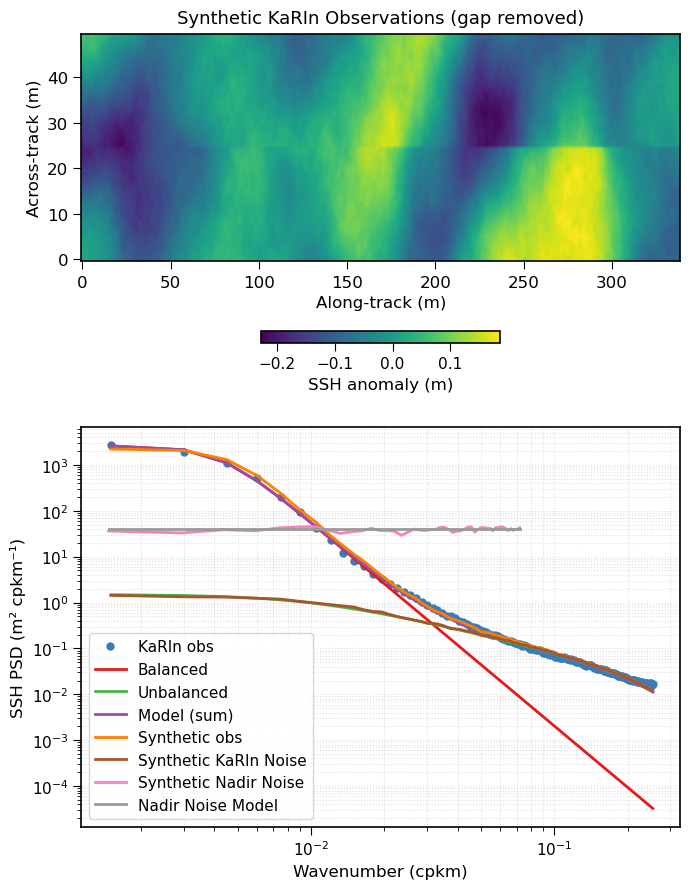

In [45]:
# karin component
h_k = hs[:, :nx*ny]  # karin signal  
h_combined = h_k  + etas_k.reshape(etas_k.shape[0], -1) # karin signal + noise

# h_syn is the combined reshaped into (time, nx, ny)
h_syn = np.zeros((hs.shape[0], ny, nx))
for i in range(hs.shape[0]):
    h_syn[i, :, :] = h_combined[i, :].reshape(ny, nx)

# ---- SPECS ----Now we compute the spectra for all the components of the model
h_syn_coords = { # we make this again because we have different number of samples to our karin coords
    'sample': np.arange(h_syn.shape[0]),
    'pixel': np.arange(0.5, h_syn.shape[1], 1.0) * karin.dy, 
    'line': np.arange(0.5, h_syn.shape[2], 1.0) * karin.dx
}

h_syn_xr = xr.DataArray(h_syn, coords = h_syn_coords, dims = ['sample', 'pixel', 'line'])
spec_h_syn = swot.mean_power_spectrum(h_syn_xr, karin.window, 'line', ['sample', 'pixel'])
spec_h_syn = spec_h_syn[int(karin.track_length/2):]

eta_k_xr = xr.DataArray(etas_k, coords = h_syn_coords, dims = ['sample', 'pixel', 'line'])
eta_k_syn = swot.mean_power_spectrum(eta_k_xr, karin.window, 'line', ['sample', 'pixel'])
spec_eta_k = eta_k_syn[int(karin.track_length/2):]

# compute the nadir spectrum
eta_nt_coords = {
    'sample': np.arange(etas_n.shape[0]),
    'nadir_line': np.arange(0.5, etas_n.shape[1], 1.0) * nadir.dy
}

eta_n_xr = xr.DataArray(etas_n, coords = eta_nt_coords, dims = ['sample', 'nadir_line'])
spec_eta_n = swot.mean_power_spectrum(eta_n_xr, nadir.window, 'nadir_line', ['sample'])
spec_eta_n = spec_eta_n[int(nadir.track_length/2):]


# ---- PLOTS ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 9), dpi=100, gridspec_kw={'height_ratios': [0.7, 0.8]})

sc = ax1.imshow(h_syn[0, :, :], aspect='auto', origin='lower')
ax1.set_title('Synthetic KaRIn Observations (gap removed)', fontsize=13, pad=8)
ax1.set_ylabel('Across‐track (m)', fontsize=12)
ax1.set_xlabel('Along‐track (m)', fontsize=12)
cbar = plt.colorbar(sc, ax=ax1, orientation='horizontal', shrink=0.4, pad=0.2)
cbar.ax.tick_params(labelsize=11)
cbar.set_label('SSH anomaly (m)', fontsize=12)


ax2.loglog(k_km[1:], karin_spec_sample_mean[1:], 'o', markersize=5, label='KaRIn obs') # from above
ax2.loglog(k_km[1:], spbalanced, lw=2, label='Balanced') # from above model
ax2.loglog(k_km[1:], spunbalanced[1:], lw=2, label='Unbalanced') # from above model
ax2.loglog(k_km[1:], (spunbalanced[1:] + spbalanced), '-', lw=2, label='Model (sum)') # from above model
ax2.loglog(k_km[1:], spec_h_syn[1:], '-', lw=2, label='Synthetic obs')
ax2.loglog(k_km[1:], spec_eta_k[1:], lw=2, label='Synthetic KaRIn Noise')
ax2.loglog(k_nadir[1:]*1e3, spec_eta_n[1:], lw=2, label='Synthetic Nadir Noise')
plt.loglog(k_nadir[1:]*1e3, spnoise_nadir[1:], label = r'Nadir Noise Model')

ax2.set_xlabel('Wavenumber (cpkm)', fontsize=12)
ax2.set_ylabel('SSH PSD (m² cpkm⁻¹)', fontsize=12)
ax2.legend(loc='lower left', fontsize=11, frameon=True)
ax2.tick_params(axis='both', which='major', labelsize=11)
ax2.grid(True, which='both', linestyle=':', alpha=0.4)

plt.tight_layout(h_pad=2)
plt.show()

#### Now use our noise models to generate synthetic SWOT observations from the NA simulation data

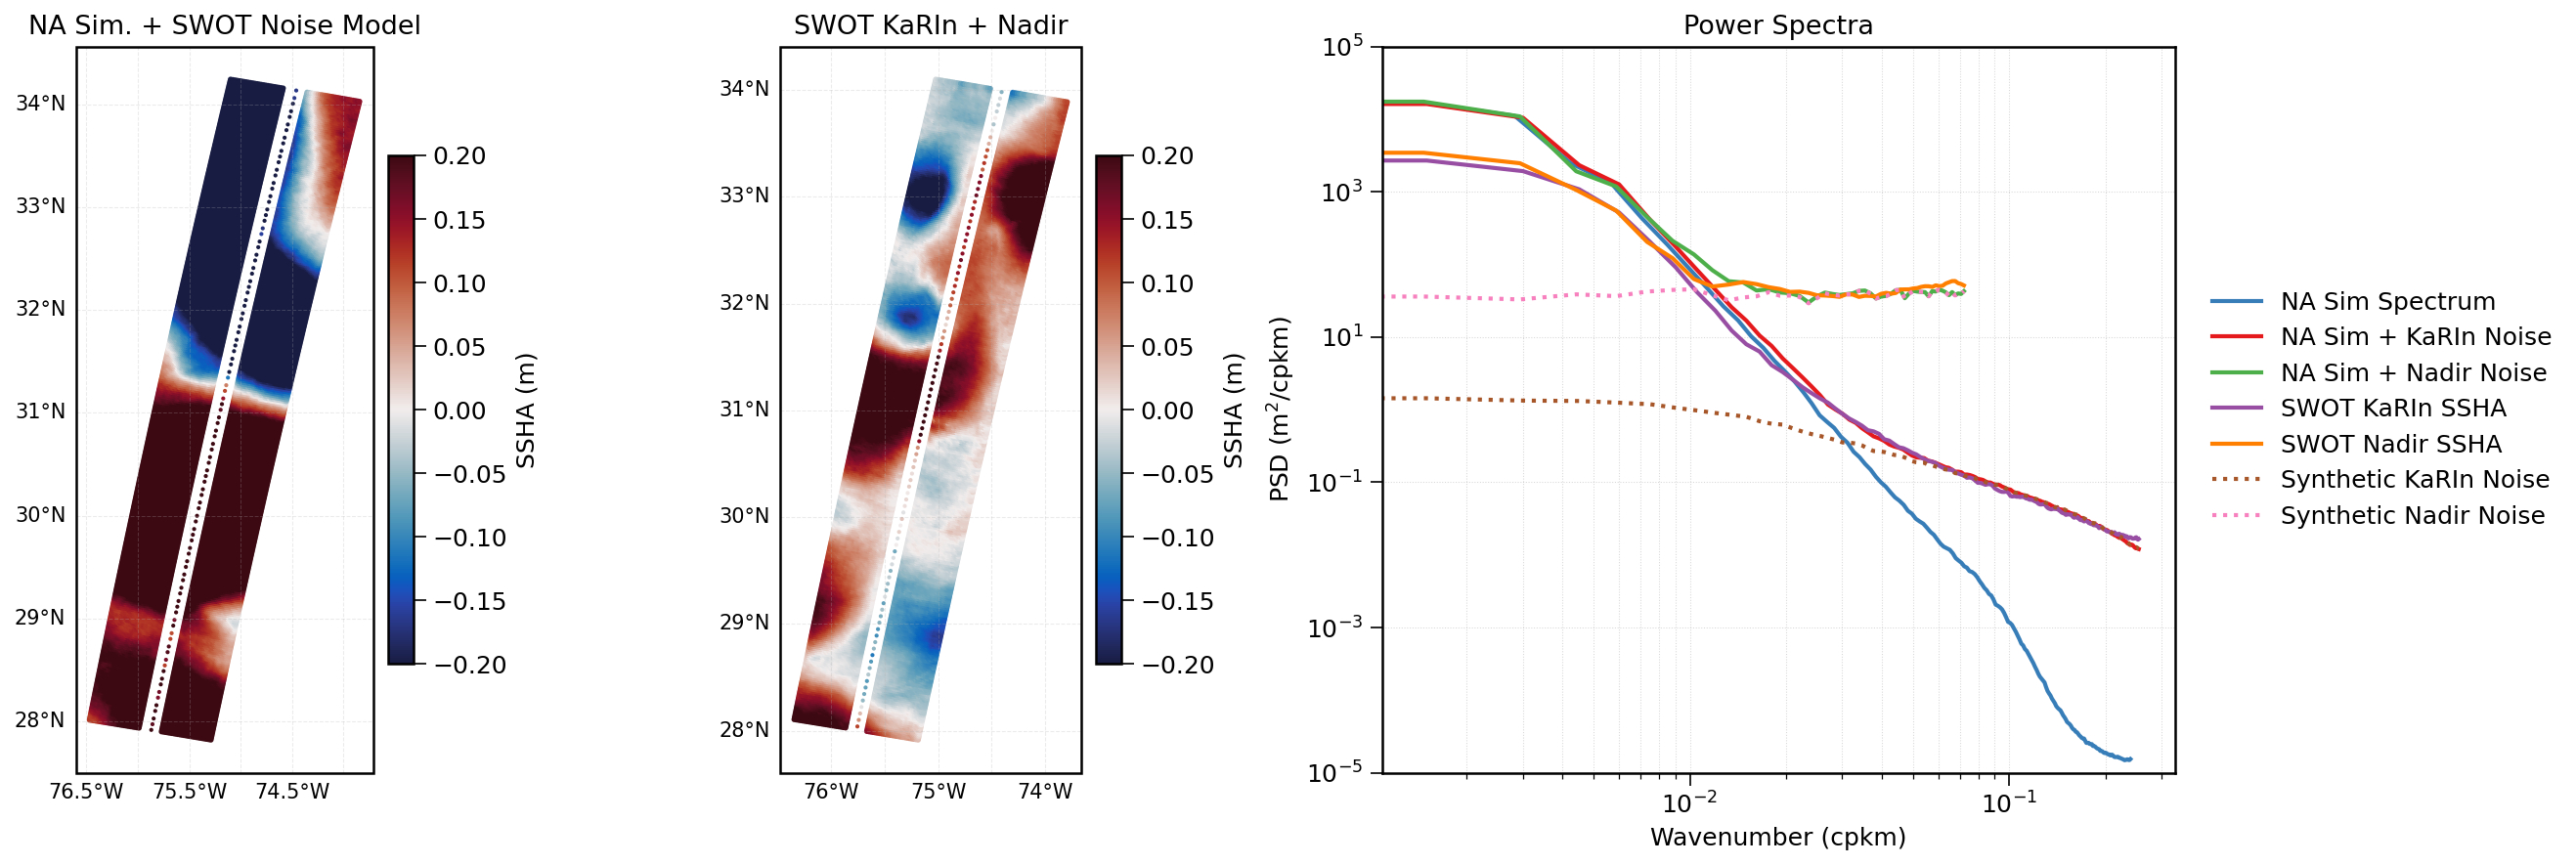

In [46]:
# Now we generate our Karin and Nadir noise based on synthetic realizations of the SWOT models 

ntime = karin_NA.ssha.shape[0] # simulation times

ssh_noisy = np.empty_like(karin_NA.ssha) # new arrays for synthetic SWOT NA data
ssh_nadir_noisy = np.empty_like(nadir_NA.ssha)

for t in range(0, ntime):

    ssh = karin_NA.ssha[t, :, :] 
    mask = np.isfinite(ssh)      # mask the gap out

    eta_k_reshaped = np.full_like(ssh, np.nan)  
    eta_k_current = etas_k[t, :, :] 

    # Direct assignment of flattened valid data:
    eta_k_reshaped[mask] = eta_k_current.T.flatten()

    # Add noise to SSH, preserving gaps:
    ssh_noisy[t, :, :] = ssh + eta_k_reshaped

    # --- Nadir ---
    ssh_nadir = nadir_NA.ssha[t, :]
    ssh_nadir_noisy[t] = ssh_nadir + etas_n[t]

    # mask_nadir = np.isfinite(ssh_nadir)
    # eta_nt = etas_n[t]
    # ssh_nadir_noisy[t, mask_nadir] = ssh_nadir[mask_nadir] + eta_nt[mask_nadir]


kt_NA_coords    = [np.arange(ntime), karin.y_coord, karin.x_coord]
ssh_noisy_xr = xr.DataArray(ssh_noisy, coords = kt_NA_coords, dims = ['sample', 'line', 'pixel'])
spec_ssh_noisy = swot.mean_power_spectrum(ssh_noisy_xr, karin.window, 'line', ['sample', 'pixel'])
spec_ssh_noisy = spec_ssh_noisy[int(karin.track_length/2):] # take the half spectrum

nad_noisy_xr   = xr.DataArray(ssh_nadir_noisy, coords = eta_nt_coords, dims = ['sample', 'nadir_line'])
spec_nad_noisy = swot.mean_power_spectrum(nad_noisy_xr, nadir.window, 'nadir_line', ['sample'])
spec_nad_noisy = spec_nad_noisy[int(nadir.track_length/2):]

karin_NA.ssh_noisy = ssh_noisy # save the generated noisy fields to our NA simulation classes 
nadir_NA.ssh_noisy = ssh_nadir_noisy

fig = plt.figure(figsize=(18, 6), dpi=150)
gs = GridSpec(1, 3, width_ratios=[1, 1, 1.6], figure=fig)

# ───── Simulation Map ─────
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
sc0 = ax0.scatter(
    NA_karin_lon.flatten(), NA_karin_lat.flatten(),
    c=ssh_noisy[index], s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o'
)
ax0.scatter(
    NA_nadir_lon, NA_nadir_lat, c=ssh_nadir_noisy[index], vmin=vmin, vmax=vmax,
    cmap=cmap, s=1, marker='o', transform=ccrs.PlateCarree()
)
ax0.coastlines()
ax0.set_title("NA Sim. + SWOT Noise Model")
gl0 = ax0.gridlines(draw_labels=True, linewidth=0.5, alpha=0.25)
gl0.top_labels = gl0.right_labels = False
cbar0 = fig.colorbar(sc0, ax=ax0, orientation='vertical', shrink=0.7, pad=0.03)
cbar0.set_label("SSHA (m)")

# ───── SWOT Map ─────
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
sc1 = ax1.scatter(
    karin.lon[index], karin.lat[index],
    c=karin.ssha[index], s=3, vmin=vmin, vmax=vmax, cmap=cmap,
    transform=ccrs.PlateCarree(), marker='o'
)
ax1.scatter(
    nadir.lon[index], nadir.lat[index],
    c=nadir.ssh[index], s=1, vmin=vmin, vmax=vmax,
    cmap=cmap, transform=ccrs.PlateCarree(), marker='o'
)
ax1.coastlines()
ax1.set_title(f'SWOT KaRIn + Nadir')
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.25)
gl1.top_labels = gl1.right_labels = False
cbar1 = fig.colorbar(sc1, ax=ax1, orientation='vertical', shrink=0.7, pad=0.03)
cbar1.set_label("SSHA (m)")

# ───── Power Spectrum ─────
ax2 = fig.add_subplot(gs[0, 2])
ax2.loglog(karin_NA.wavenumbers * 1e3, karin_NA.spec_alongtrack_av, label='NA Sim Spectrum', linewidth=2)
# ax2.loglog(nadir_NA.wavenumbers * 1e3, nadir_NA.spec_alongtrack_av, label='Sim Nadir SSH', linewidth=2)
ax2.loglog(spec_ssh_noisy.freq_line * 1e3, spec_ssh_noisy, label='NA Sim + KaRIn Noise', linewidth=2.0)
ax2.loglog(k_nadir*1e3, spec_nad_noisy, label='NA Sim + Nadir Noise', linewidth=2.0)

ax2.loglog(karin.wavenumbers * 1e3, karin.spec_alongtrack_av, '-', label='SWOT KaRIn SSHA', linewidth=2)
ax2.loglog(nadir.wavenumbers * 1e3, nadir.spec_alongtrack_av, '-', label='SWOT Nadir SSHA', linewidth=2)
ax2.loglog(k_km, spec_eta_k,':', lw=2, label='Synthetic KaRIn Noise')
ax2.loglog(k_nadir*1e3, spec_eta_n, ':', lw=2, label='Synthetic Nadir Noise')

ax2.set_xlabel("Wavenumber (cpkm)")
ax2.set_ylabel("PSD (m$^2$/cpkm)")
ax2.set_ylim(ylims)
ax2.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
ax2.grid(True, which='both', linestyle=':', linewidth=0.5)
ax2.set_title("Power Spectra")

plt.tight_layout()
plt.show()

## 4. Now we apply the balanced extraction to the new NA simulation data with synthetic SWOT noise

In [47]:
from scipy.linalg import block_diag

index = 10 # time index to estimate on 

# Build masks
mask_k = ~np.isnan(karin_NA.ssh_noisy[index])
mask_n = ~np.isnan(nadir_NA.ssh_noisy[index])

# Obs values
h_obs = np.concatenate((
    karin_NA.ssh_noisy[index][mask_k].flatten(order="C"),
    nadir_NA.ssh_noisy[index][mask_n]
))

# Obs grids
xkk = karin.x_grid[mask_k].flatten(order="C")
ykk = karin.y_grid[mask_k].flatten(order="C")
xnn = nadir.x_coord[mask_n]
ynn = nadir.y_coord[mask_n]

xobs = np.concatenate((xkk, xnn))
yobs = np.concatenate((ykk, ynn))

# Build covariance matrix
C_obs = swot.build_covariance_matrix(c, xobs, yobs)

# Build noise matrices
Nk_obs = nk(np.hypot(
    xobs[:len(xkk), None] - xobs[:len(xkk)],
    yobs[:len(xkk), None] - yobs[:len(xkk)]
))

Nn_obs = sigma**2 * np.eye(len(xnn))
N_obs = block_diag(Nk_obs, Nn_obs)

xt, yt, nxt, nyt = swot.make_target_grid(karin, extend = False)

# Estimate signal
ht_NA_sim = swot.estimate_signal_on_target(c, yt, xt, xobs, yobs, C_obs, N_obs, h_obs)

Calculating covariance matrices...
Estimating signal on target points...
Signal estimation time: 109.0315 seconds


/scratch/jskinner1/job_40821174/ipykernel_2035030/2357633725.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


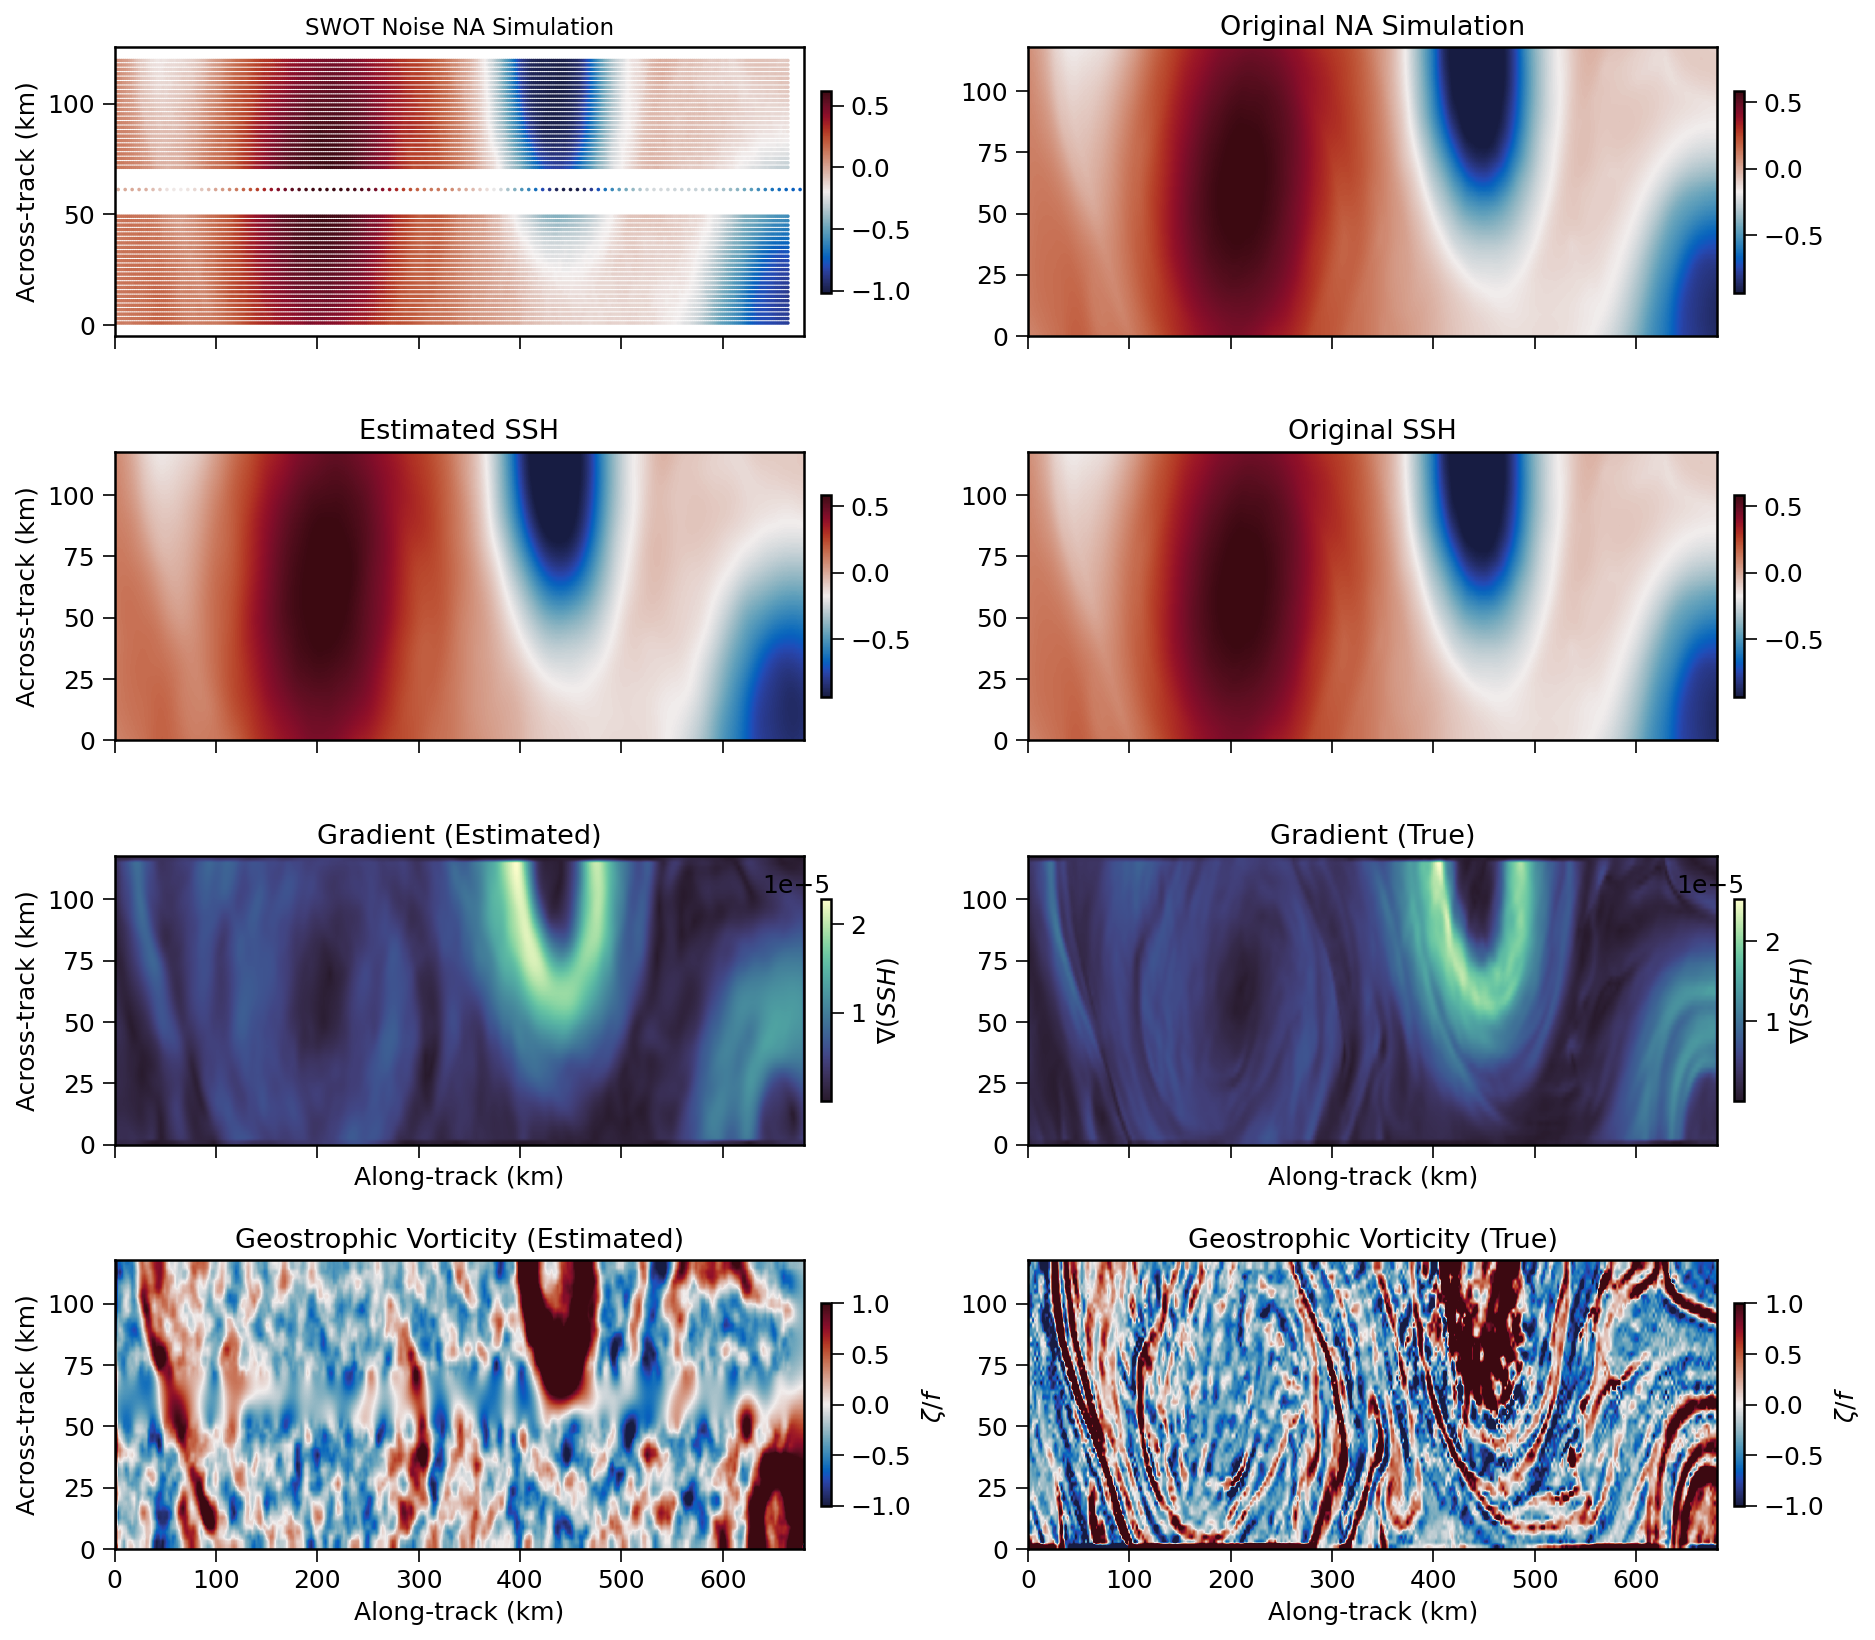

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean

# --- Prepare data ---

# Estimated SSH
ht_map = ht_NA_sim.reshape(nyt, nxt)  # (ny, nx)

# Original simulation (truth)
h_truth = karin_NA.ssh_orig[index] - np.mean(karin_NA.ssh_orig[index])  # give ssha of the original simulation

# Noisy observations (masked KaRIn + Nadir)
ssh_k_flat = karin_NA.ssh_noisy[index].flatten(order='C')
mask_k_flat = mask_k.flatten(order='C')
obs_k = ssh_k_flat[mask_k_flat]

# Shared color scale
vmin, vmax = np.nanpercentile(np.concatenate([ht_map.ravel(), h_truth.ravel()]), [2, 98])

# Gradient fields
grad_est = swot.compute_gradient(ht_map)
grad_true = swot.compute_gradient(h_truth)

# Vorticity fields
lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), nyt)
geo_vort_est = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), 2000, 2000, lats)
lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), h_truth.shape[0])
geo_vort_true = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(h_truth), 2000, 2000, lats)

# --- Create figure layout: 4 rows × 2 columns ---
fig, axes = plt.subplots(4, 2, figsize=(15, 13), sharex='col',
                         gridspec_kw={"hspace": 0.4, "wspace": 0.1})

# ===== Row 0: Observations =====
sc0 = axes[0, 0].scatter(
    ykk * 1e-3, xkk * 1e-3, c=obs_k, s=3, cmap=cmocean.cm.balance, edgecolor="none"
)
axes[0, 0].scatter(
    ynn * 1e-3, xnn * 1e-3, c=nadir_NA.ssh[index][mask_n], s=3, cmap=cmocean.cm.balance, edgecolor="none"
)
axes[0, 0].set_title("SWOT Noise NA Simulation", fontsize=11)
axes[0, 0].set_ylabel("Across-track (km)")
fig.colorbar(sc0, ax=axes[0, 0], shrink=0.7, pad=0.02)

im_obs_truth = axes[0, 1].imshow(
    h_truth.T, origin="lower",
    extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
    cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto'
)
axes[0, 1].set_title("Original NA Simulation")
fig.colorbar(im_obs_truth, ax=axes[0, 1], shrink=0.7, pad=0.02)

# ===== Row 1: SSH maps =====
im0 = axes[1, 0].imshow(ht_map, origin="lower",
                        extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 0].set_title("Estimated SSH")
axes[1, 0].set_ylabel("Across-track (km)")
fig.colorbar(im0, ax=axes[1, 0], shrink=0.7, pad=0.02)

im1 = axes[1, 1].imshow(h_truth.T, origin="lower",
                        extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 1].set_title("Original SSH")
fig.colorbar(im1, ax=axes[1, 1], shrink=0.7, pad=0.02)

# ===== Row 2: Gradient maps =====
g0 = axes[2, 0].imshow(grad_est, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[2, 0].set_title("Gradient (Estimated)")
axes[2, 0].set_ylabel("Across-track (km)")
axes[2, 0].set_xlabel("Along-track (km)")
fig.colorbar(g0, ax=axes[2, 0], shrink=0.7, pad=0.02, label=r"$\nabla(SSH)$")

g1 = axes[2, 1].imshow(grad_true.T, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[2, 1].set_title("Gradient (True)")
axes[2, 1].set_xlabel("Along-track (km)")
fig.colorbar(g1, ax=axes[2, 1], shrink=0.7, pad=0.02, label=r"$\nabla(SSH)$")

# ===== Row 3: Vorticity maps =====
v0 = axes[3, 0].imshow(geo_vort_est, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[3, 0].set_title("Geostrophic Vorticity (Estimated)")
axes[3, 0].set_ylabel("Across-track (km)")
axes[3, 0].set_xlabel("Along-track (km)")
fig.colorbar(v0, ax=axes[3, 0], shrink=0.7, pad=0.02, label=r"$\zeta / f$")

v1 = axes[3, 1].imshow(geo_vort_true.T, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[3, 1].set_title("Geostrophic Vorticity (True)")
axes[3, 1].set_xlabel("Along-track (km)")
fig.colorbar(v1, ax=axes[3, 1], shrink=0.7, pad=0.02, label=r"$\zeta / f$")

plt.tight_layout()
plt.savefig("output.png", dpi=300, bbox_inches='tight')
plt.show()


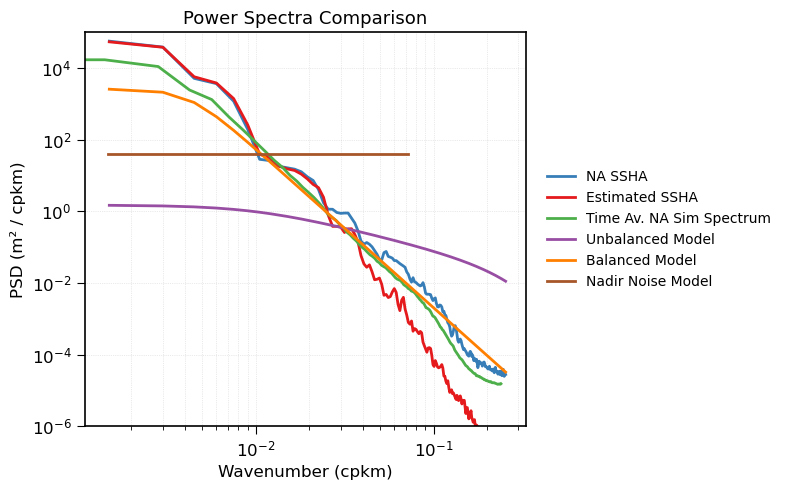

In [50]:
import xarray as xr

est_coords = { # we make this again because we have different number of samples to our karin coords
    'sample': np.arange(1), # we only did one frame
    'pixel': np.arange(0.5, ht_map.shape[0], 1.0) * karin.dy, 
    'line': np.arange(0.5, ht_map.shape[1], 1.0) * karin.dx
}

recovered_xr = xr.DataArray(ht_map[None, :, :], coords=est_coords, dims=['sample', 'pixel', 'line'])
truth_xr     = xr.DataArray(h_truth.T[None, :, :], coords=est_coords, dims=['sample', 'pixel', 'line'])

# Compute power spectra
spec_est  = swot.mean_power_spectrum(recovered_xr, karin_NA.window, dim='line', average_dims=['sample', 'pixel'])
spec_true = swot.mean_power_spectrum(truth_xr, karin_NA.window, dim='line', average_dims=['sample', 'pixel'])

# Trim to 1-sided spectrum
spec_est = spec_est[int(nx / 2):]
spec_true = spec_true[int(nx / 2):]

# Make the plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

# True and estimated SSH spectra
ax.loglog(k_km[1:], spec_true[1:], lw=2, label='NA SSHA')
ax.loglog(k_km[1:], spec_est[1:], lw=2, label='Estimated SSHA')

# NA sim & noisy spectra
ax.loglog(karin_NA.wavenumbers * 1e3, karin_NA.spec_alongtrack_av, lw=2, label='Time Av. NA Sim Spectrum')
# ax.loglog(spec_ssh_noisy.freq_line * 1e3, spec_ssh_noisy, lw=2, label='NA Sim + KaRIn Noise')
# ax.loglog(k_nadir * 1e3, spec_nad_noisy, lw=2, label='NA Sim + Nadir Noise')

# SWOT observations
# ax.loglog(karin.wavenumbers * 1e3, karin.spec_alongtrack_av, lw=2, label='SWOT KaRIn SSHA')
# ax.loglog(nadir.wavenumbers * 1e3, nadir.spec_alongtrack_av, lw=2, label='SWOT Nadir SSHA')

ax.loglog(k_km[1:], spunbalanced[1:], lw=2, label='Unbalanced Model') # from above model
ax.loglog(k_km[1:], spbalanced, '-', lw=2, label='Balanced Model') # from above model
ax.loglog(k_nadir[1:]*1e3, spnoise_nadir[1:], label = r'Nadir Noise Model')

# # Synthetic noise models
# ax.loglog(k_km, spec_eta_k, ':', lw=2, label='Synthetic KaRIn Noise')
# ax.loglog(k_nadir * 1e3, spec_eta_n, ':', lw=2, label='Synthetic Nadir Noise')

# Axes formatting
ax.set_xlabel("Wavenumber (cpkm)", fontsize=12)
ax.set_ylabel("PSD (m² / cpkm)", fontsize=12)
ax.set_ylim([1e-6, 1e5])
ax.set_title("Power Spectra Comparison", fontsize=13)
ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1.02, 0.5))
ax.grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

/scratch/jskinner1/job_40821174/ipykernel_2035030/2066617977.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


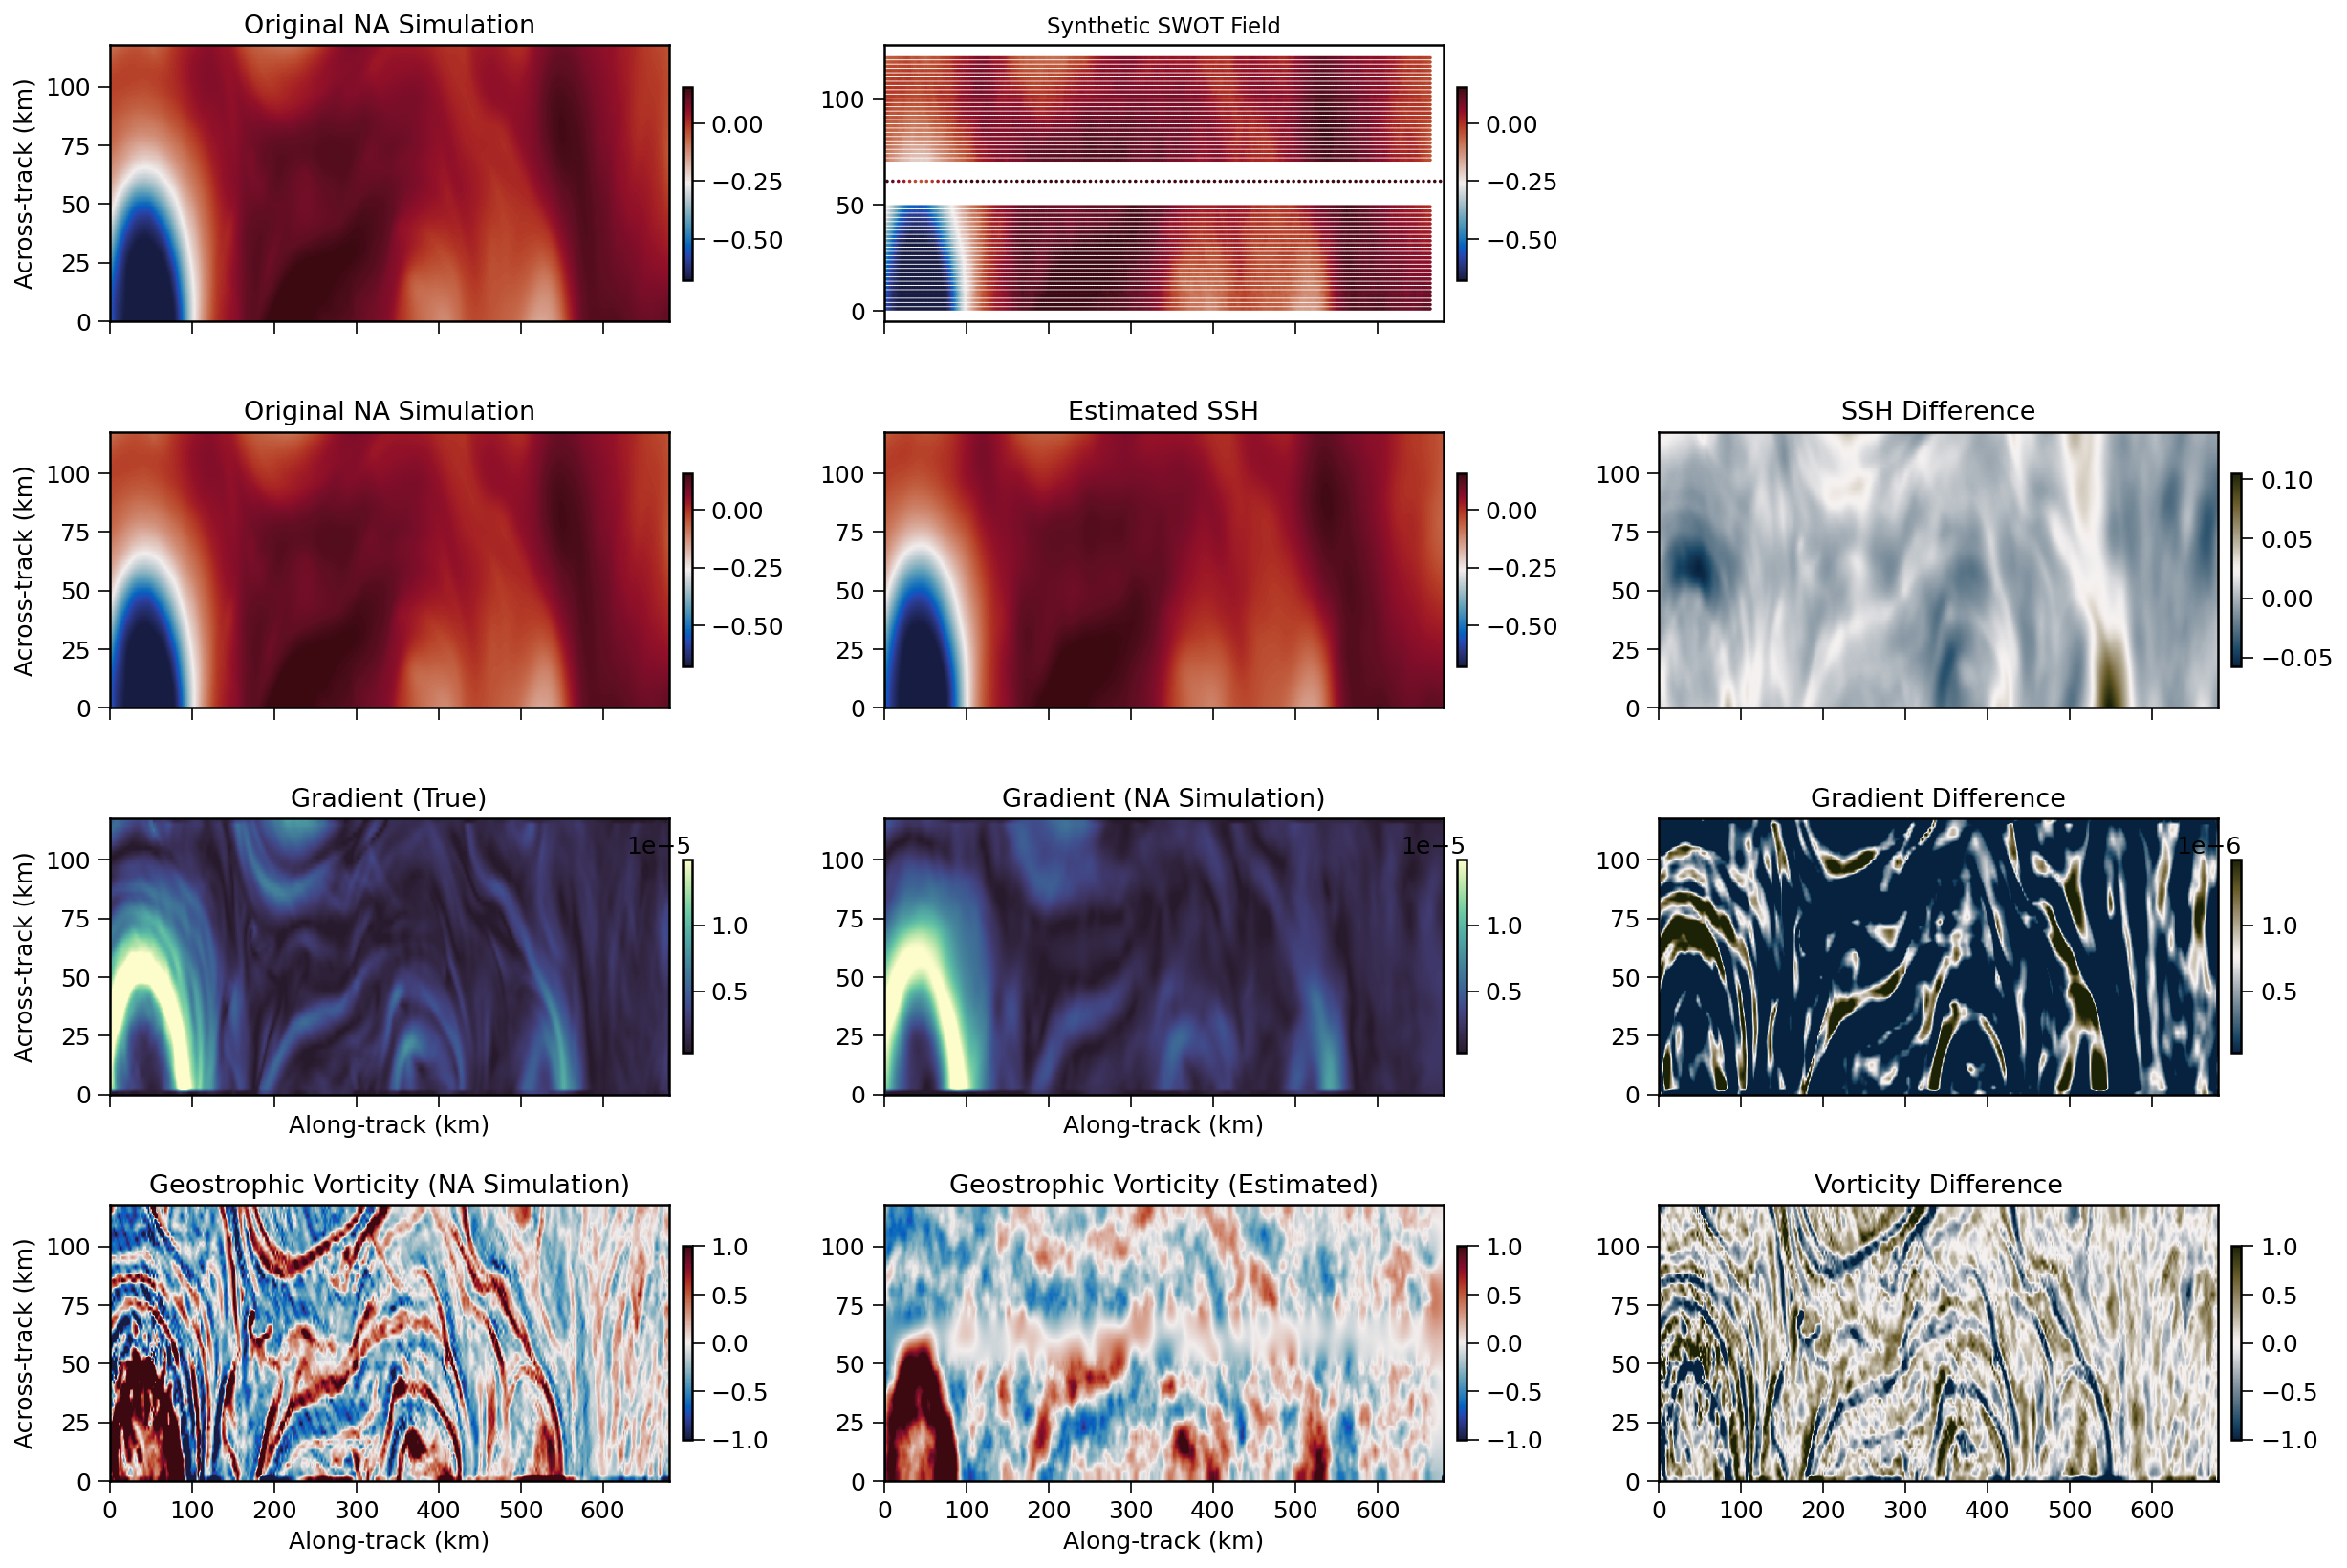

In [25]:
ht_map = ht_NA_sim.reshape(nyt, nxt)  # Estimated SSH
h_truth = karin_NA.ssh_orig[index] - np.mean(karin_NA.ssh_orig[index])  # Truth SSH

ssh_k_flat = karin_NA.ssh_noisy[index].flatten(order='C')
mask_k_flat = mask_k.flatten(order='C')
obs_k = ssh_k_flat[mask_k_flat]

grad_est = swot.compute_gradient(ht_map)
grad_true = swot.compute_gradient(h_truth)

lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), nyt)
geo_vort_est = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), karin_NA.dx, karin_NA.dy, lats)
lats = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), h_truth.shape[0])
geo_vort_true = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(h_truth), karin_NA.dx, karin_NA.dy, lats)

# --- Compute differences ---
ssh_diff = ht_map - h_truth.T
grad_diff = grad_est - grad_true.T
vort_diff = geo_vort_est - geo_vort_true.T

# --- Create figure layout: 4 rows × 3 columns ---
fig, axes = plt.subplots(4, 3, figsize=(20, 13), sharex='col',
                         gridspec_kw={"hspace": 0.4, "wspace": 0.15})

# ===== Row 0: Observations (Swapped) =====
vmin, vmax = np.nanpercentile(np.concatenate([ht_map.ravel(), h_truth.ravel()]), [2, 98])

im_obs_truth = axes[0, 0].imshow(
    h_truth.T, origin="lower",
    extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
    cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto'
)
axes[0, 0].set_title("Original NA Simulation")
axes[0, 0].set_ylabel("Across-track (km)")
fig.colorbar(im_obs_truth, ax=axes[0, 0], shrink=0.7, pad=0.02)

sc0 = axes[0, 1].scatter(
    ykk * 1e-3, xkk * 1e-3, c=obs_k, s=3, cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, edgecolor="none"
)
axes[0, 1].scatter(
    ynn * 1e-3, xnn * 1e-3, c=nadir_NA.ssh[index][mask_n], s=3, cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax, edgecolor="none"
)
axes[0, 1].set_title("Synthetic SWOT Field", fontsize=11)
fig.colorbar(sc0, ax=axes[0, 1], shrink=0.7, pad=0.02)

axes[0, 2].axis("off")

# ===== Row 1: SSH maps (Swapped) =====
im1 = axes[1, 0].imshow(h_truth.T, origin="lower",
                        extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 0].set_title("Original NA Simulation")
axes[1, 0].set_ylabel("Across-track (km)")
fig.colorbar(im1, ax=axes[1, 0], shrink=0.7, pad=0.02)

im0 = axes[1, 1].imshow(ht_map, origin="lower",
                        extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 1].set_title("Estimated SSH")
fig.colorbar(im0, ax=axes[1, 1], shrink=0.7, pad=0.02)

diff1 = axes[1, 2].imshow(ssh_diff, origin="lower",
                          extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                          cmap=cmocean.cm.diff, aspect='auto')
axes[1, 2].set_title("SSH Difference")
fig.colorbar(diff1, ax=axes[1, 2], shrink=0.7, pad=0.02)

# ===== Row 2: Gradient maps (Swapped) =====
vmin, vmax = np.nanpercentile(np.concatenate([grad_est.ravel(), grad_true.ravel()]), [2, 98])

g1 = axes[2, 0].imshow(grad_true.T, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.deep_r, vmin=vmin, vmax=vmax, aspect='auto')
axes[2, 0].set_title("Gradient (True)")
axes[2, 0].set_ylabel("Across-track (km)")
axes[2, 0].set_xlabel("Along-track (km)")
fig.colorbar(g1, ax=axes[2, 0], shrink=0.7, pad=0.02)

g0 = axes[2, 1].imshow(grad_est, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.deep_r, vmin=vmin, vmax=vmax, aspect='auto')
axes[2, 1].set_title("Gradient (NA Simulation)")
axes[2, 1].set_xlabel("Along-track (km)")
fig.colorbar(g0, ax=axes[2, 1], shrink=0.7, pad=0.02)

diff2 = axes[2, 2].imshow(grad_diff, origin="lower",
                          extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                          cmap=cmocean.cm.diff, vmin=0.1 * vmin, vmax=0.1 * vmax, aspect='auto')
axes[2, 2].set_title("Gradient Difference")
fig.colorbar(diff2, ax=axes[2, 2], shrink=0.7, pad=0.02)

# ===== Row 3: Vorticity maps (Swapped) =====
v1 = axes[3, 0].imshow(geo_vort_true.T, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[3, 0].set_title("Geostrophic Vorticity (NA Simulation)")
axes[3, 0].set_ylabel("Across-track (km)")
axes[3, 0].set_xlabel("Along-track (km)")
fig.colorbar(v1, ax=axes[3, 0], shrink=0.7, pad=0.02)

v0 = axes[3, 1].imshow(geo_vort_est, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[3, 1].set_title("Geostrophic Vorticity (Estimated)")
axes[3, 1].set_xlabel("Along-track (km)")
fig.colorbar(v0, ax=axes[3, 1], shrink=0.7, pad=0.02)

diff3 = axes[3, 2].imshow(vort_diff, origin="lower",
                          extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                          cmap=cmocean.cm.diff, vmin=-1, vmax=1, aspect='auto')
axes[3, 2].set_title("Vorticity Difference")
fig.colorbar(diff3, ax=axes[3, 2], shrink=0.7, pad=0.02)

plt.tight_layout()
plt.savefig("output_swapped_columns.png", dpi=300, bbox_inches='tight')
plt.show()


25 35


/scratch/jskinner1/job_40821174/ipykernel_2035030/3321150501.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


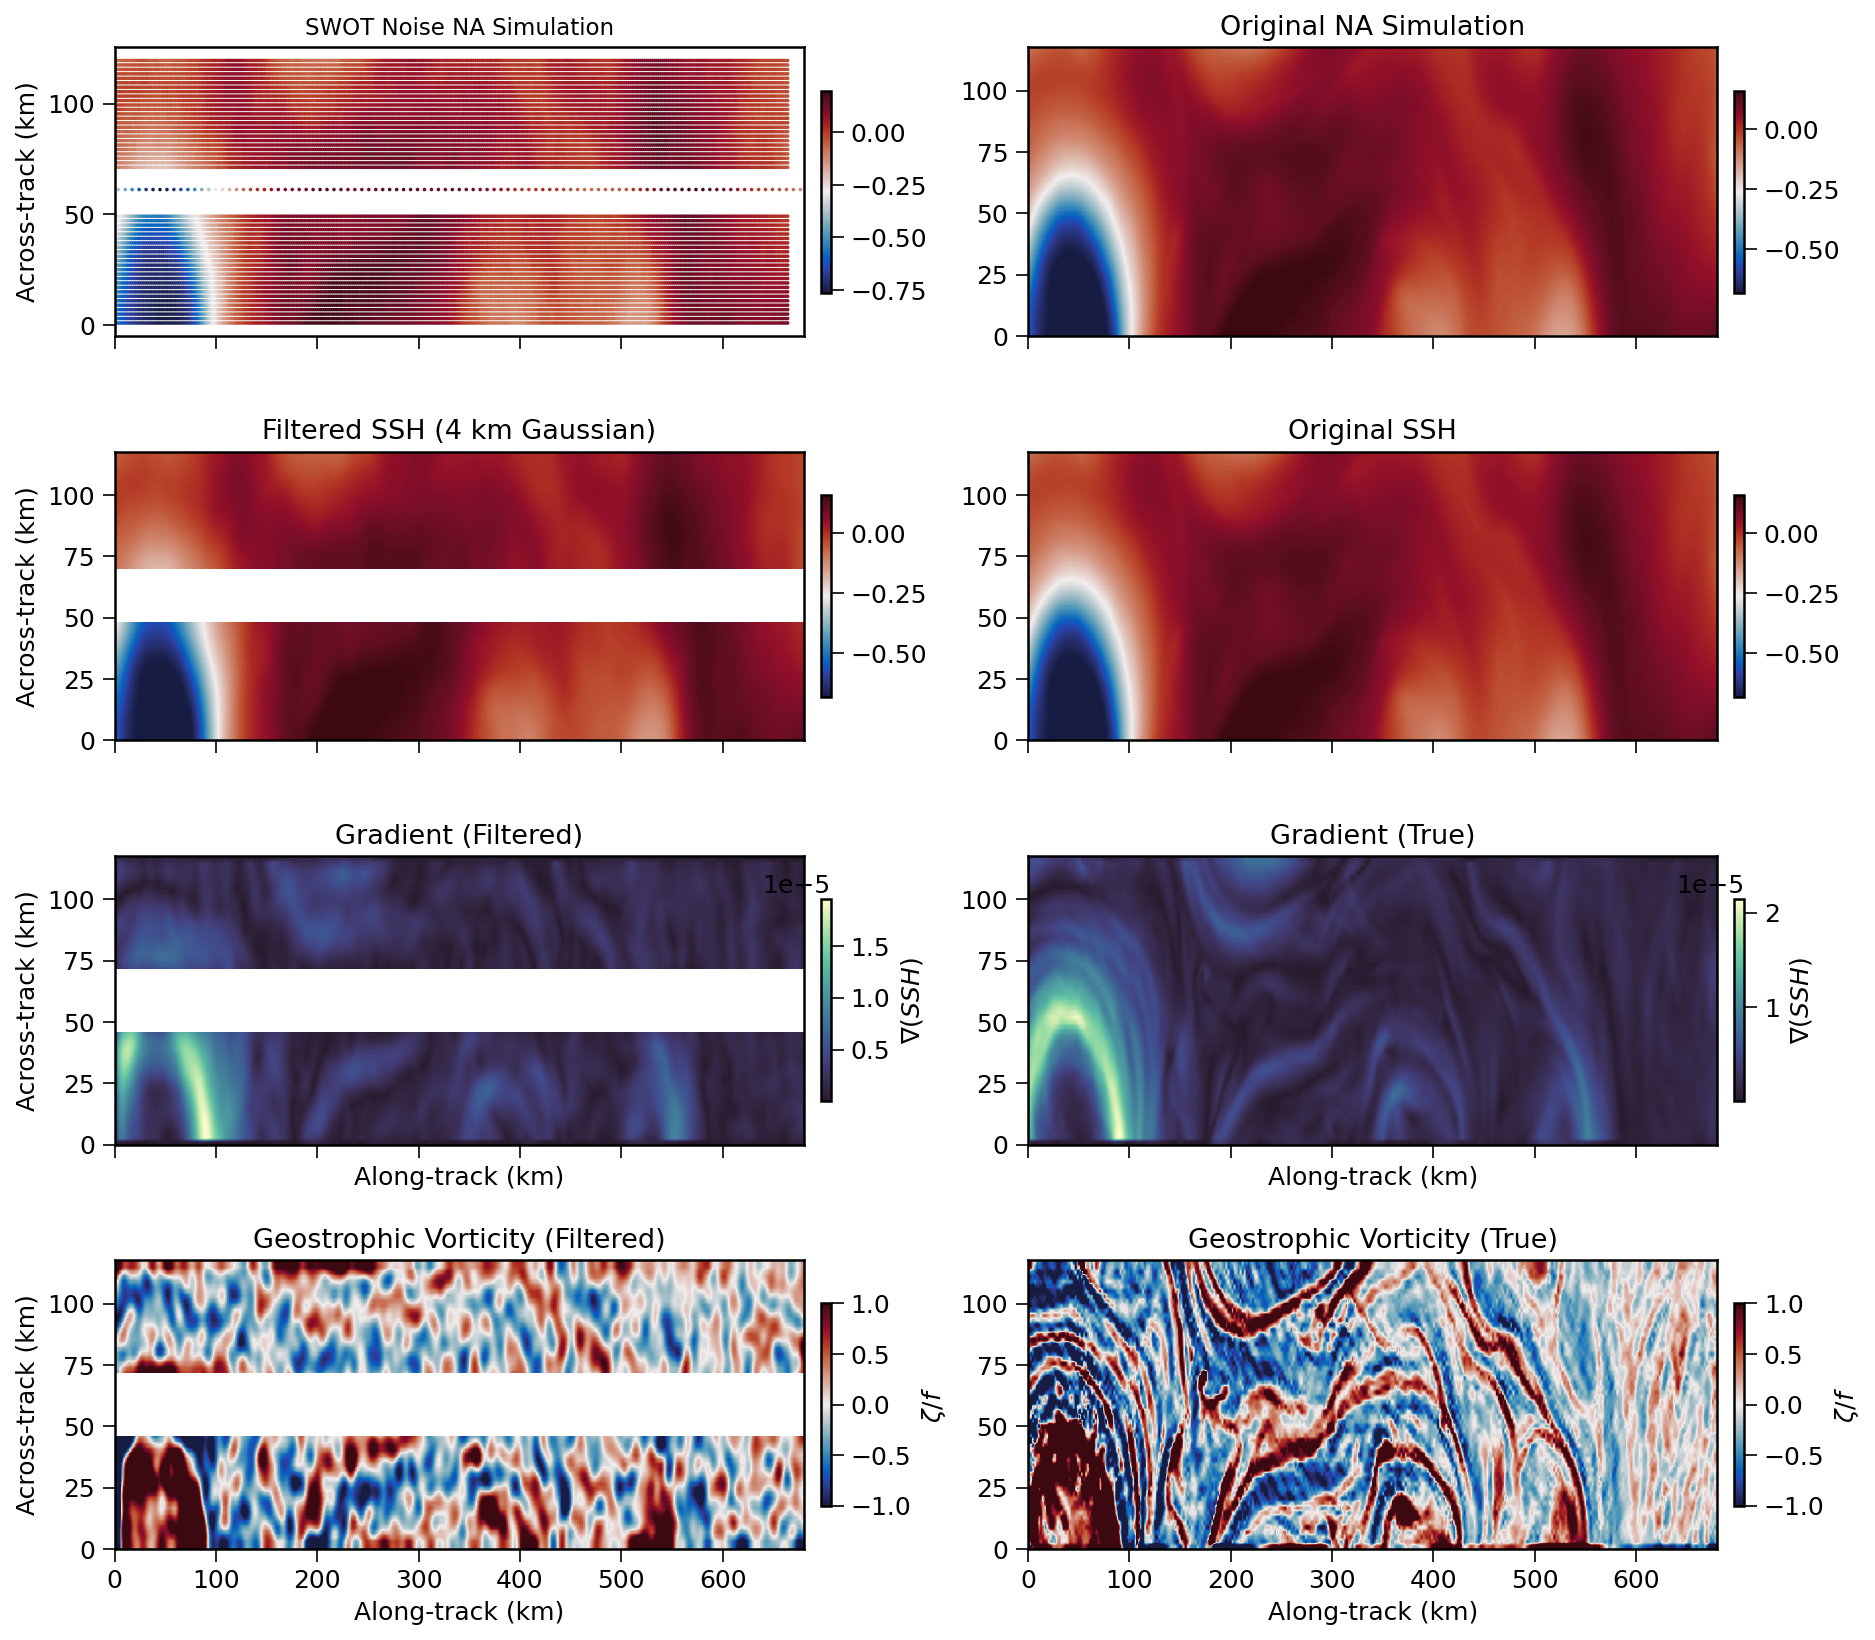

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
from scipy.ndimage import gaussian_filter

# Original simulation (truth)
h_truth = karin_NA.ssh_orig[index] - np.mean(karin_NA.ssh_orig[index])  # shape (ny, nx)

# Masked noisy observations
ssh_noisy = karin_NA.ssh_noisy[index]
mask_k = np.isfinite(ssh_noisy)

# Replace gaps with 0, create weight mask
masked_data = np.where(mask_k, ssh_noisy, 0.0)
weight = mask_k.astype(float)

# Compute Gaussian filter parameters in pixel units
dx_km = karin.dx * 1e-3
dy_km = karin.dy * 1e-3
sigma_x = 4 / dx_km
sigma_y = 4 / dy_km

# Apply Gaussian filter to data and weight
filtered_data = gaussian_filter(masked_data.T, sigma=[sigma_y, sigma_x])
filtered_weight = gaussian_filter(weight.T, sigma=[sigma_y, sigma_x])

# Normalize and restore NaNs
with np.errstate(invalid='ignore', divide='ignore'):
    h_filtered = filtered_data / filtered_weight
    h_filtered[filtered_weight == 0] = np.nan

# Reinsert 10-pixel central gap (typical for KaRIn data)
gap_width = 10
nx_total = h_filtered.shape[0]
gap_start = nx_total // 2 - gap_width // 2
gap_end = gap_start + gap_width
h_filtered[gap_start:gap_end, :] = np.nan

print(gap_start, gap_end)

# Flatten KaRIn data for scatter plot
ssh_k_flat = ssh_noisy.flatten(order='C')
mask_k_flat = mask_k.flatten(order='C')
obs_k = ssh_k_flat[mask_k_flat]

# Shared color scale
vmin, vmax = np.nanpercentile(np.concatenate([h_filtered.ravel(), h_truth.ravel()]), [2, 98])

# Gradient fields
grad_est = swot.compute_gradient(h_filtered)
grad_true = swot.compute_gradient(h_truth)

# Vorticity fields
lats_est = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), h_filtered.shape[0])
geo_vort_est = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(h_filtered), 2000, 2000, lats_est)

lats_true = np.linspace(np.nanmin(karin.lat[index]), np.nanmax(karin.lat[index]), h_truth.shape[0])
geo_vort_true = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(h_truth), 2000, 2000, lats_true)

# --- Create figure layout: 4 rows × 2 columns ---
fig, axes = plt.subplots(4, 2, figsize=(15, 13), sharex='col',
                         gridspec_kw={"hspace": 0.4, "wspace": 0.1})

# ===== Row 0: Observations =====
sc0 = axes[0, 0].scatter(
    ykk * 1e-3, xkk * 1e-3, c=obs_k, s=3, cmap=cmocean.cm.balance, edgecolor="none"
)
axes[0, 0].scatter(
    ynn * 1e-3, xnn * 1e-3, c=nadir_NA.ssh[index][mask_n], s=3, cmap=cmocean.cm.balance, edgecolor="none"
)
axes[0, 0].set_title("SWOT Noise NA Simulation", fontsize=11)
axes[0, 0].set_ylabel("Across-track (km)")
fig.colorbar(sc0, ax=axes[0, 0], shrink=0.7, pad=0.02)

im_obs_truth = axes[0, 1].imshow(
    h_truth.T, origin="lower",
    extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
    cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto'
)
axes[0, 1].set_title("Original NA Simulation")
fig.colorbar(im_obs_truth, ax=axes[0, 1], shrink=0.7, pad=0.02)

# ===== Row 1: SSH maps =====
im0 = axes[1, 0].imshow(h_filtered, origin="lower",
                        extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 0].set_title("Filtered SSH (4 km Gaussian)")
axes[1, 0].set_ylabel("Across-track (km)")
fig.colorbar(im0, ax=axes[1, 0], shrink=0.7, pad=0.02)

im1 = axes[1, 1].imshow(h_truth.T, origin="lower",
                        extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                        cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, aspect='auto')
axes[1, 1].set_title("Original SSH")
fig.colorbar(im1, ax=axes[1, 1], shrink=0.7, pad=0.02)

# ===== Row 2: Gradient maps =====
g0 = axes[2, 0].imshow(grad_est, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[2, 0].set_title("Gradient (Filtered)")
axes[2, 0].set_ylabel("Across-track (km)")
axes[2, 0].set_xlabel("Along-track (km)")
fig.colorbar(g0, ax=axes[2, 0], shrink=0.7, pad=0.02, label=r"$\nabla(SSH)$")

g1 = axes[2, 1].imshow(grad_true.T, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.deep_r, aspect='auto')
axes[2, 1].set_title("Gradient (True)")
axes[2, 1].set_xlabel("Along-track (km)")
fig.colorbar(g1, ax=axes[2, 1], shrink=0.7, pad=0.02, label=r"$\nabla(SSH)$")

# ===== Row 3: Vorticity maps =====
v0 = axes[3, 0].imshow(geo_vort_est, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[3, 0].set_title("Geostrophic Vorticity (Filtered)")
axes[3, 0].set_ylabel("Across-track (km)")
axes[3, 0].set_xlabel("Along-track (km)")
fig.colorbar(v0, ax=axes[3, 0], shrink=0.7, pad=0.02, label=r"$\zeta / f$")

v1 = axes[3, 1].imshow(geo_vort_true.T, origin="lower",
                       extent=(0, nxt * karin.dx * 1e-3, 0, nyt * karin.dy * 1e-3),
                       cmap=cmocean.cm.balance, vmin=-1, vmax=1, aspect='auto')
axes[3, 1].set_title("Geostrophic Vorticity (True)")
axes[3, 1].set_xlabel("Along-track (km)")
fig.colorbar(v1, ax=axes[3, 1], shrink=0.7, pad=0.02, label=r"$\zeta / f$")

plt.tight_layout()
plt.savefig("output.png", dpi=300, bbox_inches='tight')
plt.show()


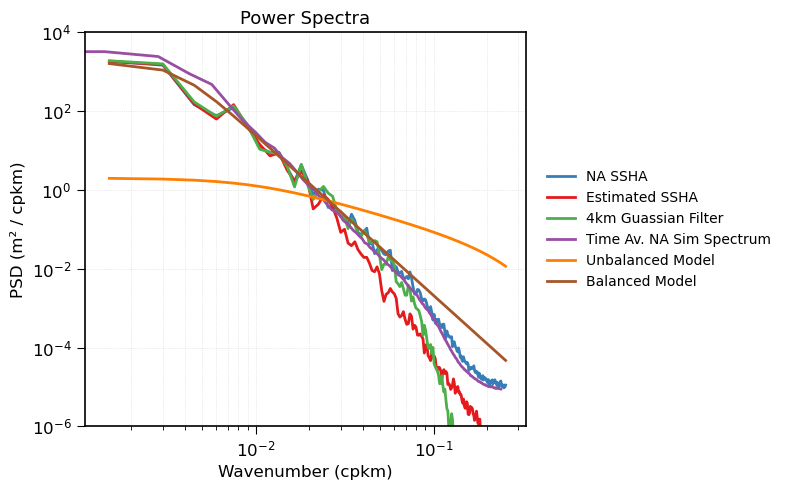

In [23]:
import xarray as xr

est_coords = { # we make this again because we have different number of samples to our karin coords
    'sample': np.arange(1), # we only did one frame
    'pixel': np.arange(0.5, ht_map.shape[0], 1.0) * karin.dy, 
    'line': np.arange(0.5, ht_map.shape[1], 1.0) * karin.dx
}

guassian_xr = xr.DataArray(h_filtered[None, :, :], coords=est_coords, dims=['sample', 'pixel', 'line'])
spec_guass  = swot.mean_power_spectrum(guassian_xr, karin_NA.window, dim='line', average_dims=['sample', 'pixel'])
spec_guass = spec_guass[int(nx / 2):]

# Make the plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

# True and estimated SSH spectra
ax.loglog(k_km[1:], spec_true[1:], lw=2, label='NA SSHA')
ax.loglog(k_km[1:], spec_est[1:], lw=2, label='Estimated SSHA')
ax.loglog(k_km[1:], spec_guass[1:], lw=2, label='4km Guassian Filter')

# NA sim & noisy spectra
ax.loglog(karin_NA.wavenumbers * 1e3, karin_NA.spec_alongtrack_av, lw=2, label='Time Av. NA Sim Spectrum')
# ax.loglog(spec_ssh_noisy.freq_line * 1e3, spec_ssh_noisy, lw=2, label='NA Sim + KaRIn Noise')
# ax.loglog(k_nadir * 1e3, spec_nad_noisy, lw=2, label='NA Sim + Nadir Noise')

# SWOT observations
# ax.loglog(karin.wavenumbers * 1e3, karin.spec_alongtrack_av, lw=2, label='SWOT KaRIn SSHA')
# ax.loglog(nadir.wavenumbers * 1e3, nadir.spec_alongtrack_av, lw=2, label='SWOT Nadir SSHA')

ax.loglog(k_km[1:], spunbalanced[1:], lw=2, label='Unbalanced Model') # from above model
ax.loglog(k_km[1:], spbalanced, '-', lw=2, label='Balanced Model') # from above model
#ax.loglog(k_nadir[1:]*1e3, spnoise_nadir[1:], label = r'Nadir Noise Model')

# # Synthetic noise models
# ax.loglog(k_km, spec_eta_k, ':', lw=2, label='Synthetic KaRIn Noise')
# ax.loglog(k_nadir * 1e3, spec_eta_n, ':', lw=2, label='Synthetic Nadir Noise')

# Axes formatting
ax.set_xlabel("Wavenumber (cpkm)", fontsize=12)
ax.set_ylabel("PSD (m² / cpkm)", fontsize=12)
ax.set_ylim([1e-6, 1e4])
ax.set_title("Power Spectra", fontsize=13)
ax.legend(fontsize=10, loc='center left', bbox_to_anchor=(1.02, 0.5))
ax.grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

### Loop over all frames and save the data  

Note here we are saving now a 64 grid rather than the original 60 grid points

We also get some threshold of Nans, like if 30\% or more of the data are NaN then reject it. Just the gap is 0.16 (16%) so if we set threshold to 30% then we are saying the KaRIn data should have no more than ~15% of NaN values

In [ ]:
import pickle
import numpy as np
from joblib import Parallel, delayed
os.environ["NUMEXPR_MAX_THREADS"] = "8" # With 128GB of RAM 4 works

name = "NA_sim"
run_dir = f"./NA_sim_outputs/{name}_P{pass_num:03d}"
os.makedirs(run_dir, exist_ok=True)

print("dirs made")

# ---- Function for processing a single frame ----
def process_frame(index):
    try:
        print(index)
        # Build masks
        mask_k = ~np.isnan(karin_NA.ssh_noisy[index])
        mask_n = ~np.isnan(nadir_NA.ssh_noisy[index])
        
        # Obs values
        h_obs = np.concatenate((
            karin_NA.ssh_noisy[index][mask_k].flatten(order="C"),
            nadir_NA.ssh_noisy[index][mask_n]
        ))
        
        # # Obs grids
        # xkk = karin.x_grid[mask_k].flatten(order="C")
        # ykk = karin.y_grid[mask_k].flatten(order="C")
        # xnn = nadir.x_coord[mask_n]
        # ynn = nadir.y_coord[mask_n]
        
        # xobs = np.concatenate((xkk, xnn))
        # yobs = np.concatenate((ykk, ynn))
        
        # # Build covariance matrix
        # C_obs = swot.build_covariance_matrix(c, xobs, yobs)
        
        # # Build noise matrices
        # Nk_obs = nk(np.hypot(
        #     xobs[:len(xkk), None] - xobs[:len(xkk)],
        #     yobs[:len(xkk), None] - yobs[:len(xkk)]
        # ))
        
        # Nn_obs = sigma**2 * np.eye(len(xnn))
        # N_obs = block_diag(Nk_obs, Nn_obs)
        
        xt, yt, nxt, nyt = swot.make_target_grid(karin, extend = True)
        
        # Estimate signal
        ht_NA_sim = swot.estimate_signal_on_target(c, yt, xt, xobs, yobs, C_obs, N_obs, h_obs)
        ht_map = ht_NA_sim.reshape(nyt, nxt)

        lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), nyt)
        gvort = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), karin_NA.dx, karin_NA.dy, lats)

        basename = f"P{pass_num:03d}_C{shared_cycles[index]:03d}_{index:03d}"
        filename_SSH = os.path.join(run_dir, f"{basename}_SSH.npy")
        filename_gvort = os.path.join(run_dir, f"{basename}_gvort.npy")
        np.save(filename_SSH, ht_map)
        np.save(filename_gvort, gvort)
        print(f"Frame {index:03d} → saved `{filename_SSH}`")
        
        return filename_SSH
    except Exception as e:
        print(f"Skipping Frame: {index:03d} could not be processed: {e}")
        return None

#process_frame(1)

# ---- Run in parallel ----
n_frames = karin_NA.ssha.shape[0]
print(n_frames)
results = Parallel(n_jobs=4, backend='loky')(
    delayed(process_frame)(idx) for idx in range(n_frames)
)

# ---- Save the karin and nadir classes ----
# save these so we have all the parameters if we need them later (e.g., lats, lons etc.)
with open(os.path.join(run_dir, f'karin_class_NA_sim.pkl'), 'wb') as f:
    pickle.dump(karin, f)
with open(os.path.join(run_dir, f'nadir_class_NA_sim.pkl'), 'wb') as f:
    pickle.dump(nadir, f)
print(f"Saved karin and nadir class objects to '{run_dir}/'")

dirs made
101


In [29]:
with open(os.path.join(run_dir, f'karin_class_NA_sim.pkl'), 'wb') as f:
    pickle.dump(karin, f)
with open(os.path.join(run_dir, f'nadir_class_NA_sim.pkl'), 'wb') as f:
    pickle.dump(nadir, f)
print(f"Saved karin and nadir class objects to '{run_dir}/'")

Saved karin and nadir class objects to './NA_sim_outputs/NA_sim_P022/'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean

# ── reshape the map and pick colour limits 
ht_map = ht.reshape(nyt, nxt)
vmin, vmax = np.nanpercentile(ht_map, [2, 98])   # robust limits

# ── build the figure
fig, axes = plt.subplots(4, 1, figsize=(10, 13), sharex=True,
                         gridspec_kw={"hspace": 0.4})

sc = axes[0].scatter(
    karin.y_grid * 1e-3, karin.x_grid * 1e-3,
    c=karin.ssha[index, :, :], s=6, cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax, edgecolor="none"
)
sc = axes[0].scatter(
    xn * 1e-3, yn * 1e-3,
    c=nadir.ssh[index, :], s=6, cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax, edgecolor="none"
)
axes[0].set_title("Observed SSH")
axes[0].set_title("Cycle: {}".format(shared_cycles[index]), fontsize=11, loc='right')
axes[0].set_title("Pass: {:03d}".format(pass_number), fontsize=11, loc='left')
#axes[0].set_xlabel("along-track (km)")
axes[0].set_ylabel("across-track (km)")
axes[0].set_aspect("auto")
fig.colorbar(sc, ax=axes[0], orientation='vertical', shrink=0.7, pad=0.02)

lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), 64)
print(lats.shape)
geo_vort = swot.compute_geostrophic_vorticity_fd(np.ma.masked_invalid(ht_map), 2000, 2000, lats)


# 1. gridded estimate (imshow)
im0 = axes[1].imshow(
    ht_map,
    origin="lower",
    extent=(0, nxt * karin.dx * 1e-3,        # km
            0, nyt * karin.dy * 1e-3),       # km
    aspect="auto",
    cmap=cmocean.cm.balance,
    vmin=vmin, vmax=vmax
)
axes[1].set_title("Generated SSH")
axes[1].set_ylabel("across-track (km)")
fig.colorbar(im0, ax=axes[1], orientation='vertical', shrink=0.7, pad=0.02)

im1 = axes[2].imshow(
    swot.compute_gradient(ht_map),
    origin="lower",
    extent=(0, nxt * karin.dx * 1e-3,        # km
            0, nyt * karin.dy * 1e-3),       # km
    aspect="auto",
    cmap=cmocean.cm.deep_r
)
axes[2].set_title("Gradient")
axes[2].set_ylabel("across-track (km)")
fig.colorbar(im1, ax=axes[2], orientation='vertical', shrink=0.7, pad=0.02, label=r'$\nabla(SSH)$')

im1 = axes[3].imshow(
    geo_vort,
    origin="lower",
    extent=(0, nxt * karin.dx * 1e-3,        # km
            0, nyt * karin.dy * 1e-3),       # km
    aspect="auto",
    vmin = -1, 
    vmax = 1,
    cmap=cmocean.cm.balance
)
axes[3].set_title("Geostrophic Vorticity")
axes[3].set_xlabel("along-track distance (km)")
axes[3].set_ylabel("across-track (km)")
fig.colorbar(im1, ax=axes[3], orientation='vertical', shrink=0.7, pad=0.02, label=r'$\zeta / f$')

# shared colour-bar
plt.tight_layout()
plt.show()


### PDF of Cyclonicity

In [ ]:
from scipy import stats
import scipy.stats as st
from scipy.stats import kurtosis
from matplotlib.offsetbox import AnchoredText

# Make a plot of the skewness and kurtosis of the vorticity
vals = geo_vort.ravel()
vals = vals[~np.isnan(vals)]

mean_vort = np.mean(vals)
skew_vort = stats.skew(vals, bias=False)
kurt = kurtosis(vals, fisher=True, bias=False)

# 4. Build histogram (density) and get bin‐centers
n_bins = 50
hist, edges = np.histogram(vals, bins=n_bins, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])

# 5. Plot
plt.figure(figsize=(5, 5))

# filled histogram
plt.hist(vals, bins=n_bins, density=True,
         alpha=0.4, edgecolor='k', label='Histogram')

# line through the PDF
plt.plot(centers, hist, '-', lw=2, label='PDF')

# annotate mean & skewness
txt = (
    f"Mean = {mean_vort:.3e}\n"
    f"Skewness = {skew_vort:.3f}\n"
    f"Kurtosis = {kurt:.3f}"
)
at = AnchoredText(txt, loc='lower left', prop=dict(size=11), frameon=True, pad=0.6, borderpad=0.8)
at.patch.set(alpha=0.7, facecolor='white', edgecolor='none')
plt.gca().add_artist(at)

plt.axvline(0, color='k', linestyle='--', linewidth=1, label='x = 0')


# labels & legend
plt.xlabel(r'$\zeta / f$')
plt.ylabel('PDF')
plt.title('PDF of Cyclonicity')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

## 6. Compare interpolation with Nadir to without Nadir 

In [ ]:
index = 1 

# observed ssha values
h_karin = karin.ssha[index].T.flatten(order="C")[mask_k_flat]

# Karin noise and signal on observed pixels
N_obs  = nk(np.hypot(
                    xk[:mask_k_flat.sum(), None] - xk[:mask_k_flat.sum()],
                    yk[:mask_k_flat.sum(), None] - yk[:mask_k_flat.sum()]))

C_obs = swot.build_covariance_matrix(c,  xk, yk)

ht_karonly = swot.estimate_signal_on_target(c, xt, yt, xk, yk, C_obs, N_obs, h_karin)
ht_karonly_map = ht_karonly.reshape(nyt, nxt)

#Check this part because the lap difference doesnt match what visual inspection of the differences suggests

In [ ]:
fields = [
    ("Observed SSH", lambda: (karin.ssha[index], karin.y_grid, karin.x_grid)),
    ("Karin + Nadir", lambda: (ht_map, None, None)),
    ("Karin only", lambda: (ht_karonly_map, None, None)),
    ("Difference", lambda: (ht_map - ht_karonly_map, None, None)),
]

# ── define your per-panel vmin/vmax pairs ──
orig_vlims = [
    (-0.2, 0.2),       # for Observed SSH
    (-0.2, 0.2),       # for Generated SSH
    (-0.2, 0.2),       # for 2 km Gaussian
    (-0.02, 0.02),     # for Gen − 2 km Gauss
]
lap_vlims = [
    (-3e-9, 3e-9),   # for ∇²(Observed SSH)
    (-1e-9, 1e-9),   # for ∇²(Generated SSH)
    (-1e-9, 1e-9),   # for ∇²(2 km Gaussian)
    (-2e-10, 2e-10),   # for ∇²(Gen − 2 km Gauss)
]

fig, axes = plt.subplots(4, 2, figsize=(16, 13),
                         sharex='col', sharey='col',
                         gridspec_kw={"wspace":0.3, "hspace":0.4})

for i, (title, getter) in enumerate(fields):
    field, kyt, kxt = getter()

    # left: original
    ax = axes[i, 0]
    vmin_o, vmax_o = orig_vlims[i]
    if kyt is not None:
        m = ax.scatter(kyt*1e-3, kxt*1e-3, c=field, s=3,
                       cmap=cmocean.cm.balance,
                       vmin=vmin_o, vmax=vmax_o,
                       edgecolor="none")
        sc = ax.scatter(xn * 1e-3, yn * 1e-3, c=nadir.ssh[index, :], 
                        s=6, cmap=cmocean.cm.balance, vmin=vmin_o, vmax=vmax_o, 
                        edgecolor="none")
    else:
        m = ax.imshow(field,
                      origin="lower",
                      extent=(0, nxt*karin.dx*1e-3,
                              0, nyt*karin.dy*1e-3),
                      aspect="auto",
                      cmap=cmocean.cm.balance,
                      vmin=vmin_o, vmax=vmax_o)
    ax.set_title(title)
    if i == 0:
        ax.set_title(f"Cycle: {shared_cycles[index]}", fontsize=11, loc='right')
        ax.set_title(f"Pass: {pass_number:03d}",       fontsize=11, loc='left')
    if i > 0:
        ax.set_xlabel("along-track (km)")
    ax.set_ylabel("cross-track (km)")
    fig.colorbar(m, ax=ax, orientation='vertical', shrink=0.7, pad=0.02)

    # right: Laplacian (but for the last row do diff of Laplacians)
    ax2 = axes[i, 1]
    vmin_l, vmax_l = lap_vlims[i]
    if i == len(fields) - 1:
        # final panel: difference of the individual laplacians
        lap = (swot.compute_laplacian(ht_map)
             - swot.compute_laplacian(ht_karonly_map))
        title2 = r"$\nabla^2 {\rm Difference}$"
    else:
        lap = swot.compute_laplacian(field)
        title2 = r"$\nabla^2$(" + title + ")"

    if kyt is not None:
        m2 = ax2.scatter(kyt*1e-3, kxt*1e-3, c=lap, s=3,
                         cmap=cmocean.cm.curl,
                         vmin=vmin_l, vmax=vmax_l,
                         edgecolor="none")
    else:
        m2 = ax2.imshow(lap,
                        origin="lower",
                        extent=(0, nxt*karin.dx*1e-3,
                                0, nyt*karin.dy*1e-3),
                        aspect="auto",
                        cmap=cmocean.cm.curl,
                        vmin=vmin_l, vmax=vmax_l)
    ax2.set_title(title2)
    if i > 0:
        ax2.set_xlabel("along-track (km)")
    ax2.set_ylabel("cross-track (km)")
    fig.colorbar(m2, ax=ax2, orientation='vertical', shrink=0.7, pad=0.02)



In [ ]:
# Spectra of nadir vs no nadir 

# y_coord  = dy_karin * np.arange(track_length)            # m along track
# x_coord  = dx_karin * np.arange(total_width)             # m across track

gen_sample_mean = compute_gen_sample_mean(ht_map, karin.x_coord, karin.y_coord) # here the x y is our track dims from above not xobs yobs
gen_sample_mean_karonly = compute_gen_sample_mean(ht_karonly_map, x, y)

# plot the weighted fit
plt.figure(figsize=(5.5,5), dpi=120)
plt.loglog(k_km[1:], spectrum_sample_mean[1:],'o', label = 'SSHA data')
plt.loglog(k_km[1:], spbalanced,label = r'Balanced:$\sigma$=%5.3f, $\rho$=%5.3f' % tuple(poptcwg_karin[0:2]))
plt.loglog(k_km[1:], spunbalanced[1:],label = r'Unbalanced:$\sigma$=%5.3f, $\gamma$=%5.3f, $\rho$=%5.3f' % tuple(poptcwg_karin[2:5]))
plt.loglog(k_km[1:], (spunbalanced[1:]+spbalanced),'--',label = 'Model (sum)')
plt.loglog(k_km[1:], gen_sample_mean[1:],'-', label = 'Karin + Nadir')
plt.loglog(k_km[1:], gen_sample_mean_karonly[1:],'--b', label = 'Karin only')
plt.xlabel('wavenumber (cpkm)')
plt.ylabel('SSH power spectral density (m$^2$ cpkm$^{-1}$)')
plt.legend(loc = 'lower left', bbox_to_anchor=(1.05, 0.5))
#plt.xlim(1e-3, 3e-1)
plt.title('Weighted fit karin data')

In [ ]:
print(ht_map.shape)
print(karin.ssha.shape)

## Experiments 

In [ ]:
# Experimenting with building the grid from the data lats and lons

from scipy.linalg import block_diag

index = 5 # time index 

mask_k = ~np.isnan(karin.ssha[index])
mask_n = ~np.isnan(nadir.ssh[index]) # N.B we are using SSH here because we aren't subtracting the time mean from the nadir

#  masks for karin and nadir
mask_k_flat = mask_k.T.flatten(order="C")             # transpose to match meshgrid order
mask_full   = np.concatenate((mask_k_flat, mask_n))   # len = nx*ny + nn

# Now we build our observation points from the data grid directly
xk, yk, xt, yt = swot.make_karin_points_from_data(karin, index) # build grids from the data lat, lons
xn, yn = swot.make_nadir_points_from_data(karin, nadir, index) # build grids from the data lat, lons

xobs = np.concatenate((xk, xn))
yobs = np.concatenate((yk, yn))

# observed ssha values
h_obs = np.concatenate((
    karin.ssha[index].T.flatten(order="C")[mask_k_flat],   # Karin
    nadir.ssh[index][mask_n]                               # Nadir
))

# covariance for observed points
C_obs = swot.build_covariance_matrix(c,  xobs, yobs) # we already built this above
#C_obs = C

# Karin noise block on observed pixels
Nk_obs  = nk(np.hypot(
                    xobs[:mask_k_flat.sum(), None] - xobs[:mask_k_flat.sum()],
                    yobs[:mask_k_flat.sum(), None] - yobs[:mask_k_flat.sum()]))

# Nadir noise block (white noise on diagonal)
Nn_obs  = sigma**2 * np.eye(mask_n.sum())

# assemble block-diagonal noise matrix
N_obs = block_diag(Nk_obs, Nn_obs)

# solve on the reduced system 
#xt, yt, nxt, nyt = swot.make_target_grid(karin, extend = True) # make our target grid with the gap filled
ht = swot.estimate_signal_on_target(c, xt.T.flatten(order="C"), yt.T.flatten(order="C"), xobs, yobs, C_obs, N_obs, h_obs)

xk, yk, xt, yt = swot.make_karin_points_from_data(karin, 1) # build grids from the data lat, lons
xn, yn = swot.make_nadir_points_from_data(karin, nadir, 1) # build grids from the data lat, lons

xobs = np.concatenate((xk, xn))
yobs = np.concatenate((yk, yn))

print(xobs.shape)
print(N_obs.shape)
print(Nk_obs.shape)
print(Nn_obs.shape)
print(mask_k.shape)
print(mask_n.shape)
print(xt.shape)

plt.figure(figsize=(8, 6))
plt.scatter(xobs.flatten(), yobs.flatten(), c = karin.ssha[index].T.flatten(order="C"), label='Observed', s=1)
plt.scatter(xt.flatten(), yt.flatten(), marker = 'x', s=1, label='Target')

plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Observed vs Target Points')
plt.legend()
plt.tight_layout()
plt.show()